In [1]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import pandas as pd

import matplotlib 
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np

from scipy import optimize
from scipy.optimize import curve_fit
from numpy import random, nanmax, argmax, unravel_index
from scipy.spatial.distance import pdist, cdist, squareform

import scipy.signal

import scipy.interpolate
import random

import seaborn as sns

from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.animation as animation

import itertools

from sklearn import cluster, datasets, mixture

import h5py
from collections import Counter



In [2]:
top_dir = ""

# Directory with data

home_dir = top_dir + "Data/"

# Directory for output images

image_dir = top_dir + "Figures/Images/"

# directory for movies

movie_dir = top_dir + "Movies/"


In [3]:
# Read datafile into Pandas dataframe

eve = pd.read_csv(home_dir + "eve_data_longform_w_nuclei_060520.csv")

# sort 

eve = eve.sort_values(['nucleus_id','time'])

# input viterbi states are 1 for off, 2 for one promoter on, 3 for both on cuz MATLAB
# convert to 0,1,2

eve['v_state'] = eve['v_state'] - 1


In [4]:
# store this as reference

eve_in = eve.copy()

In [5]:
# embryo and movie identifiers

eve['embryo'] = eve['nucleus_id'].astype('int')
eve['movie'] = eve['nucleus_id'].round(0)

In [6]:
# read in info about movies

eve_movies = pd.read_csv(home_dir + "eve_data_movie_info.csv")
eve_movies = eve_movies.set_index('movie')

In [7]:
# upstream analysis doesn't orient movies properly

eve['xPosF'] = eve['xPos']
eve['yPosF'] = eve['yPos']

eve_movies['a_xF'] = eve_movies['a_x']
eve_movies['a_yF'] = eve_movies['a_y']
eve_movies['p_xF'] = eve_movies['p_x']
eve_movies['p_yF'] = eve_movies['p_y']

for mi, m in eve_movies.iterrows():
    df = eve[eve.movie == mi]
    if m.d_up == 0:
        eve.loc[df.index,'yPosF'] = 255 - df['yPos']
    
    if m.a_left == 0:
        eve_movies.loc[mi,'a_xF'] = 1024 - m['a_x']
        eve_movies.loc[mi,'a_yF'] = m['p_y']
        eve_movies.loc[mi,'p_xF'] = 1024 - m['p_x']
        eve_movies.loc[mi,'p_yF'] = m['a_y']

In [8]:
# identify nuclei tracked for a short period of time

tracklens = {}

for nid,p in eve.groupby('nucleus_id'):
    t = p['time'].values 
    tracklens[nid] = (t[-1]-t[0])

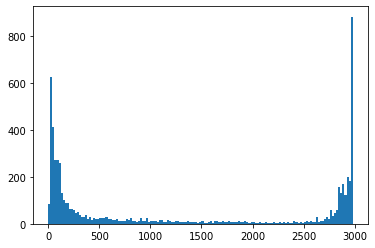

In [9]:
h = plt.hist(list(tracklens.values()),bins=range(0,3000,20))

In [10]:
eve_pretrack = eve.copy()

In [11]:
# filter out nuclei tracked for only a few frames

good = []
for nid in tracklens:
    if tracklens[nid] >= 2000:
        good.append(nid)
eve = eve[eve.nucleus_id.isin(good)]

In [12]:
# filter wandering nuclei

dt = {}
for nid,p in eve.groupby('nucleus_id'):
    df = p[p.time > 600]
    points = np.zeros((len(df),2))
    points[:,0] = df.xPos.values
    points[:,1] = df.yPos.values
    d = 0
    for i in range(0,len(points)-1):
        d += scipy.spatial.distance.euclidean(points[i],points[i+1])
    d /= (len(points)-1)
    dt[nid] = (d)
        

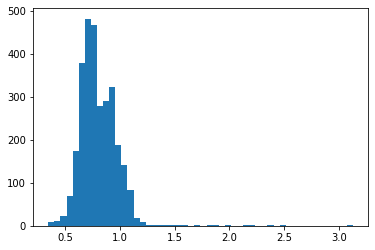

In [13]:
h = plt.hist(list(dt.values()),bins=50)

In [14]:
eve_prewander = eve.copy()

In [15]:
# filter out nuclei that over travel 

good = []
for nid in dt:
    if dt[nid] <= 1.5:
        good.append(nid)
eve = eve[eve.nucleus_id.isin(good)]

In [16]:
# number of nuclei remaining 

print ("Number of nuclei remaining: ", len(eve_in.groupby('nucleus_id')))

# number of data points remaining 

print ("Number of data points remaining: ", len(eve_in))

Number of nuclei remaining:  6716
Number of data points remaining:  499305


In [17]:
# number of nuclei remaining 

print ("Number of nuclei remaining: ", len(eve.groupby('nucleus_id')))

# number of data points remaining 

print ("Number of data points remaining: ", len(eve))

Number of nuclei remaining:  2959
Number of data points remaining:  430073


In [18]:
# Functions to save and read data

def saveall(file = ""):
    if file != "":
        eve.to_hdf(file,'eve')
        eve_movies.to_hdf(file,'eve_movies')
        eve_stripes.to_hdf(file,'eve_stripes')
        mhmm.to_hdf(file,'mhmm')
        eve_nuc.to_hdf(file,'eve_nuc')

def loadall(file = ""):
    if file != "":
        print ("Loading")
        eve = pd.read_hdf(file,'eve')
        eve_movies = pd.read_hdf(file,'eve_movies')
        eve_stripes = pd.read_hdf(file,'eve_stripes')
        mhmm = pd.read_hdf(file,'mhmm')
        eve_nuc = pd.read_hdf(file,'eve_nuc')

In [19]:
# DATA HOUSEKEEPTING

# create minute and 5 minute time bins

eve['time_m'] = np.round(eve['time']/60).astype('int')
eve['time_m5'] = (np.round(eve['time']/300)*5).astype('int')

# round particle and nucleus ids
# these sometimes load in funny

eve['particle_id'] = eve['particle_id'].astype('float64').round(4)
eve['nucleus_id'] = eve['nucleus_id'].round(4)

# column that sets nuclei with no spot to fluo 0
eve['fluo_nonan'] = eve['fluo'].fillna(0)


In [20]:
# calculate average y position for each nucleus

eve['yPosmean'] = 0

inds = []
data = []

for nid,p in eve.groupby('nucleus_id'):
    inds.extend(p.index)
    s = p['yPos'].mean()
    data.extend(len(p) * [s])   
eve.loc[inds,'yPosmean'] = data

In [21]:
eve['v_state_nonan'] = 0
eve.loc[eve['v_state'].notnull(), 'v_state_nonan'] = eve[eve['v_state'].notnull()]['v_state'].astype('int')

# for various purposes need to create a binary indicator for whether nucleus is or isn't bursting
# v_state_all sets state to [0,1] and sets all unfit rows to 0

eve['v_state_all'] = 0
eve.loc[eve['v_state'].notnull(), 'v_state_all'] = eve[eve['v_state'].notnull()]['v_state'].astype('int')
eve.loc[eve['v_state_all'] > 0,'v_state_all'] = 1
eve['v_fluo_nonan'] = eve['v_fluo'].fillna(0)

In [22]:
# routine for running multiple iterations of Gaussian mixture model
# to cluster into stripes
# requires accurate stripe count as input 

#random_states = np.random.randint(1000000,size=1000000).astype('int')
#np.save(open('random_seeds_1000000.npy', 'wb'), random_states)

random_states = np.load(open(home_dir + 'random_seeds_1000000.npy', 'rb'))
random_state_index = 0

def gmm_stripe_nofit(X,n,trials=10):
    
    global random_state_index
    a = []
    for i in range(0,len(X)):
        a.append([])
        
    t = 0
     
    while t < trials:
        gmm = mixture.GaussianMixture(n_components=n, covariance_type='tied',random_state=random_states[random_state_index])
        gmm.fit(X)
        p = gmm.predict(X)
        pp = np.zeros(n)
        for i in range(0,n):
            pp[i] = np.mean([x for x,y in zip(X[:,0],p) if y == i])
        s = sorted(range(0,n),key = lambda l: pp[l])
        sg = {}
        npp = np.zeros(n)
        for i in range(0,n):
            sg[s[i]] = i
            npp[i] = pp[s[i]]
            
        # gmm sometimes splits one stripe into two
        # these groups will have x means that are too close to each other
        
        if np.min(npp[1:]-npp[:-1]) > 100:
            t += 1
            for i,g in enumerate(p):
                a[i].append(sg[g])
        random_state_index += 1
        
    o = [np.round(np.mean(a[i]),0) for i in range(0,len(X))]
    
    return o


In [23]:
# Stripe assignment
# Warning this one is a bit slow (takes about 20m on a typical laptop)

plt.ioff()

stripe_line = {}
stripe_info = []

steps = 8
times = np.linspace(1500,3000,steps)

movies = [1,2,3,4,5,6,7,8,9,10,11]

for mi,m in eve_movies[eve_movies.index.isin(movies)].iterrows():
    print (mi)
    
    stripe_line[mi] = {}
    
    n = int(m.stripes)
    
    df = eve[eve.movie == mi]
    fap = scipy.stats.linregress(df.xPosF,df.ap_raw)
    calls = {}
    x = {}
    y = {}
    o = {}
    
    #
    # initial stripe calls
    # 
    
    for ti,t in enumerate(times[0:-2]):

        df = eve[(eve.movie == mi) & (eve.time >= times[ti]) & (eve.time <= times[ti+2]) & (eve.v_state_all == 1)]
        x[t] = df['xPosF'].values
        y[t] = df['yPosF'].values
        inds = df.index
        d = np.column_stack((x[t],y[t]))
        o[t] = gmm_stripe_nofit(d,n,trials=25)
        for i,s in list(zip(inds,o[t])):
            if i not in calls:
                calls[i] = []
            calls[i].append(s)
                
    # 
    # select points with consistent calls
    #
    
    xin = []
    yin = []
    cin = []
    
    for i,c in calls.items():
        if len(set(c)) == 1:
            xin.append(eve.loc[i].xPosF)
            yin.append(eve.loc[i].yPosF)
            cin.append(int(c[0]))
            
    fig,ax = plt.subplots(1,1,figsize=(5,3))
    ax.scatter(xin,yin,c=cin,linewidth=0)
    ax.set_xlim(0,1024)
    ax.set_ylim(0,256)
    ax.set_title("Movie %d" % (mi))
    
    #
    # fit line to low and high median values for each stripe
    #
    
    f = {}
    stripe_slope = {}
    
    for s in range(0,n):
        xt = []
        yt = []
        for j in [64,192]:
            p = np.array([[x,y] for x,y,c in zip(xin,yin,cin) if (c == s and y <= j+ 64 and y >= j-64)])
            xt.append(np.median(p[:,0]))
            yt.append(np.median(p[:,1]))
        
        ax.scatter(xt,yt,c='red',linewidth=0)
        
        if xt[0] == xt[1]:
            xt[0] += .1
            
        f[s] = scipy.stats.linregress(xt,yt)  
        stripe_slope[s] = f[s][0]

        xp = np.arange(0,1024)
        yp = xp * f[s][0] + f[s][1]
        ax.plot(xp,yp)
        
    plt.savefig(image_dir + "/Stripe_Fits/%d.png" % (mi))
    plt.close()       
    
    #
    # now with fixed slope find intercept for original subsets
    #
    
    b = {}
    
    for ti,t in enumerate(times[0:-2]):
        
        b[t] = {}
        
        for s in range(0,n):
            p = np.array([[x,y] for x,y,c in zip(x[t],y[t],o[t]) if (c == s and y <= j+ 64 and y >= j-64)])
            xt = p[:,0]
            yt = p[:,1]
            b[t][s] = np.mean(yt - f[s][0]*xt)     
        
    #
    # now linearize slope v time for each stripe
    #
    
    bf = {}
    
    for s in range(0,n):
        bt = []
        bb = []
        for ti,t in enumerate(times[0:-2]):
            bt.append(t)
            bb.append(b[t][s])
        bf[s] = scipy.stats.linregress(bt,bb)
            
    for ti,t in enumerate(times[0:-2]):
        
        fig,ax = plt.subplots(1,1,figsize=(5,3))
        ax.scatter(x[t],y[t],c=o[t],linewidth=0)
        ax.set_xlim(0,1024)
        ax.set_ylim(0,256)
        ax.set_title("Movie %d Time %d" % (mi,t))
            
        for si in range(0,n):
            tsb = bf[si][0] * t + bf[si][1]
            xp = np.arange(0,1024)
            yp = xp * f[si][0] + tsb
            ax.plot(xp,yp)
        
        plt.savefig(image_dir + "/Stripe_Fits/%d_%d.png" % (mi,ti))
        plt.close()
    

    for si in range(0,n):
               
        # compute x position of stripe at y = 128 at t = 35 mins for registration 
        
        # slope
        tsm = f[si][0]
        
        # y-intercept at time 35 mins
        tsb = bf[si][0] * 35 * 60 + bf[si][1]
        
        # x position from slope and y-intercept in middle of image
        x_35 = (128-tsb)/tsm 
        
        # convert to AP
        ap_35 = (x_35 - m.a_xF) / (m.p_xF - m.a_xF) 
        
        # store stripe information for dataframe
        stripe_info.append([mi,si,si+m.first_stripe,tsm,f[si][1],bf[si][0],bf[si][1],x_35,ap_35])

columns = ['movie','stripe_index','stripe','slope','intercept','b_slope','b_intercept','x35','ap35']            
eve_stripes = pd.DataFrame(data = stripe_info, columns=columns)

eve_stripes['ap_reg'] = 0

for s in [1,2,3,4,5,6,7]:
    df = eve_stripes[eve_stripes.stripe == s]
    ap35_m = np.mean(df['ap35'])
    eve_stripes.loc[df.index,'ap_reg'] = ap35_m - df['ap35'] 
    
eve_stripes = eve_stripes.set_index(['movie','stripe_index'])
    
eve['burst_stripe'] = 0
eve['burst_stripe_ap'] = 0
eve['burst_stripe_d'] = 0
eve['burst_stripe_ap_d'] = 0
eve['burst_stripe_xPos_reg'] = 0
eve['burst_stripe_ap_reg'] = 0
eve['burst_stripe_xPos_reg_corr_d'] = 0
eve['burst_stripe_xPos_reg_corr'] = 0
eve['burst_stripe_ap_reg_corr'] = 0
eve['burst_stripe_id'] = 0

inds = []
loc_sa = []
loc_ap = []
loc_sd = []
loc_apd = []
loc_regx = []
loc_regap = []
loc_xprd = []
loc_xprc = []
loc_aprc = []
loc_sid = []

eve.loc[inds,'burst_stripe'] = loc_sa
eve.loc[inds,'burst_stripe_ap'] = loc_ap
eve.loc[inds,'burst_stripe_d'] = loc_sd
eve.loc[inds,'burst_stripe_ap_d'] = loc_apd
eve.loc[inds,'burst_stripe_xPos_reg'] = loc_regx
eve.loc[inds,'burst_stripe_ap_reg'] = loc_regap
eve.loc[inds,'burst_stripe_xPos_reg_corr_d'] = loc_xprd
eve.loc[inds,'burst_stripe_xPos_reg_corr'] = loc_xprc
eve.loc[inds,'burst_stripe_ap_reg_corr'] = loc_aprc
eve.loc[inds,'burst_stripe_id'] = loc_sid
    
for mi,m in eve_movies[eve_movies.index.isin(movies)].iterrows():
    n = int(m.stripes)    
    df = eve[eve.movie == mi]
    
    for nid, ndf in df.groupby('nucleus_id'):
       
        # compute distance of nucleus at every time point to nearest stripe

        isa = []
        for pi,p in ndf[ndf.time > 1500].iterrows():
            xp = p['xPosF']
            yp = p['yPosF']
            t = p['time']

            xds = []
            for si in range(0,n):
                sinfo = eve_stripes.loc[mi,si]
                tsm = sinfo.slope
                tsb = sinfo.b_slope * max(t,1500) + sinfo.b_intercept

                # inferred x position given y
                xpi = (yp-tsb)/tsm
                
                # distance along x
                xds.append(np.abs(xp-xpi))
                
            isa.append(np.argmin(xds))
        
        # assign nucleus to stripe it is closest to most often
        
        sa = max(set(isa), key=isa.count)
        
        # compute various stripe based corrections
        
        sinfo = eve_stripes.loc[mi,sa]
        tsm = sinfo.slope
        
        for pi,p in ndf.iterrows():
            
            xp = p['xPosF']
            yp = p['yPosF']
            t  = p['time']
            
            # index for updating dataframe
            inds.append(pi)
            
            # true stripe
            loc_sa.append(sa + m.first_stripe)
            
            # raw ap position 
            ap = (xp-m.a_xF)/(m.p_xF - m.a_xF)
            # adjusted across movies
            ap += sinfo['ap_reg']
            loc_ap.append(ap)     
            
            # x-position of stripe center at given y
            
            tsb = sinfo.b_slope * max(t,1500) + sinfo.b_intercept
            xpi = (yp-tsb)/tsm
                
            # distance along x
            xd = xp - xpi
            loc_sd.append(xd)
            
            # store deviation from stripe center in AP units
            apd = xd / (m.p_xF - m.a_xF)
            loc_apd.append(apd)
            
            # registered x is xd + stripe position at y = 128
            xp_y128 = (128-tsb)/tsm
            xpr = xd + xp_y128
            loc_regx.append(xpr)
            
            # ap equivalent of registered xp
            apr = (xpr-m.a_xF)/(m.p_xF - m.a_xF)
            # adjusted across movies
            apr += sinfo['ap_reg']
            loc_regap.append(apr)
            
            # correct for stripe movement
            xprd = sinfo['b_slope'] * (t - 35*60) / tsm
            loc_xprd.append(xprd)
            
            xprc = xpr + xprd
            loc_xprc.append(xprc)

            aprc = (xprc-m.a_xF)/ (m.p_xF - m.a_xF) 
            aprc += sinfo['ap_reg']
            loc_aprc.append(aprc)       
            
            ap_halfwidth = .01
            
            if apd < -ap_halfwidth:
                loc_sid.append(sa + m.first_stripe - .33333333)
            elif apd > ap_halfwidth:
                loc_sid.append(sa + m.first_stripe + .33333333)
            else:
                loc_sid.append(sa + m.first_stripe)
                
eve.loc[inds,'burst_stripe'] = loc_sa
eve.loc[inds,'burst_stripe_ap'] = loc_ap
eve.loc[inds,'burst_stripe_d'] = loc_sd
eve.loc[inds,'burst_stripe_ap_d'] = loc_apd
eve.loc[inds,'burst_stripe_xPos_reg'] = loc_regx
eve.loc[inds,'burst_stripe_ap_reg'] = loc_regap
eve.loc[inds,'burst_stripe_xPos_reg_corr_d'] = loc_xprd
eve.loc[inds,'burst_stripe_xPos_reg_corr'] = loc_xprc
eve.loc[inds,'burst_stripe_ap_reg_corr'] = loc_aprc
eve.loc[inds,'burst_stripe_id'] = loc_sid

plt.ion()

1
2
3
4
5
6
7
8
9
10
11


In [24]:
# gmm bootstrapping

eve_gmmrep = eve.copy()

allmovies = [1,2,3,4,5,6,7,8,9,10,11]

rep = -1

for lom in allmovies:
    
    rep += 1
    
    movies = [m for m in allmovies if m != lom]

    stripe_line = {}
    stripe_info = []

    steps = 8
    times = np.linspace(1500,3000,steps)

    for mi,m in eve_movies[eve_movies.index.isin(movies)].iterrows():
        
        print (lom,mi,random_state_index)

        stripe_line[mi] = {}

        n = int(m.stripes)

        df = eve_gmmrep[eve_gmmrep.movie == mi]
        fap = scipy.stats.linregress(df.xPosF,df.ap_raw)
        calls = {}
        x = {}
        y = {}
        o = {}

        #
        # initial stripe calls
        # 

        for ti,t in enumerate(times[0:-2]):

            df = eve_gmmrep[(eve_gmmrep.movie == mi) & (eve_gmmrep.time >= times[ti]) & (eve_gmmrep.time <= times[ti+2]) & (eve_gmmrep.v_state_all == 1)]
            x[t] = df['xPosF'].values
            y[t] = df['yPosF'].values
            inds = df.index
            d = np.column_stack((x[t],y[t]))
            o[t] = gmm_stripe_nofit(d,n,trials=25)
            for i,s in list(zip(inds,o[t])):
                if i not in calls:
                    calls[i] = []
                calls[i].append(s)

        # 
        # select points with consistent calls
        #

        xin = []
        yin = []
        cin = []

        for i,c in calls.items():
            if len(set(c)) == 1:
                xin.append(eve_gmmrep.loc[i].xPosF)
                yin.append(eve_gmmrep.loc[i].yPosF)
                cin.append(int(c[0]))
                
        #
        # fit line to low and high median values for each stripe
        #

        f = {}
        stripe_slope = {}

        for s in range(0,n):
            xt = []
            yt = []
            for j in [64,192]:
                p = np.array([[x,y] for x,y,c in zip(xin,yin,cin) if (c == s and y <= j+ 64 and y >= j-64)])
                xt.append(np.median(p[:,0]))
                yt.append(np.median(p[:,1]))

            if xt[0] == xt[1]:
                xt[0] += .1

            f[s] = scipy.stats.linregress(xt,yt)  
            stripe_slope[s] = f[s][0]

            xp = np.arange(0,1024)
            yp = xp * f[s][0] + f[s][1]
  

        #
        # now with fixed slope find intercept for original subsets
        #

        b = {}

        for ti,t in enumerate(times[0:-2]):

            b[t] = {}

            for s in range(0,n):
                p = np.array([[x,y] for x,y,c in zip(x[t],y[t],o[t]) if (c == s and y <= j+ 64 and y >= j-64)])
                xt = p[:,0]
                yt = p[:,1]
                b[t][s] = np.mean(yt - f[s][0]*xt)     

        #
        # now linearize slope v time for each stripe
        #

        bf = {}

        for s in range(0,n):
            bt = []
            bb = []
            for ti,t in enumerate(times[0:-2]):
                bt.append(t)
                bb.append(b[t][s])
            bf[s] = scipy.stats.linregress(bt,bb)

        for ti,t in enumerate(times[0:-2]):

            for si in range(0,n):
                tsb = bf[si][0] * t + bf[si][1]
                xp = np.arange(0,1024)
                yp = xp * f[si][0] + tsb

        for si in range(0,n):

            # compute x position of stripe at y = 128 at t = 35 mins for registration 

            # slope
            tsm = f[si][0]

            # y-intercept at time 35 mins
            tsb = bf[si][0] * 35 * 60 + bf[si][1]

            # x position from slope and y-intercept in middle of image
            x_35 = (128-tsb)/tsm 

            # convert to AP
            ap_35 = (x_35 - m.a_xF) / (m.p_xF - m.a_xF) 

            # store stripe information for dataframe
            stripe_info.append([mi,si,si+m.first_stripe,tsm,f[si][1],bf[si][0],bf[si][1],x_35,ap_35])

    columns = ['movie','stripe_index','stripe','slope','intercept','b_slope','b_intercept','x35','ap35']            
    eve_stripes = pd.DataFrame(data = stripe_info, columns=columns)

    eve_stripes['ap_reg'] = 0

    for s in [1,2,3,4,5,6,7]:
        df = eve_stripes[eve_stripes.stripe == s]
        ap35_m = np.mean(df['ap35'])
        eve_stripes.loc[df.index,'ap_reg'] = ap35_m - df['ap35'] 

    eve_stripes = eve_stripes.set_index(['movie','stripe_index'])

    eve_gmmrep['burst_stripe_%d' % rep] = 0
    eve_gmmrep['burst_stripe_%d_ap' % rep] = 0


    inds = []
    loc_sa = []
    loc_ap = []
    loc_sd = []
    loc_apd = []
    loc_regx = []
    loc_regap = []
    loc_xprd = []
    loc_xprc = []
    loc_aprc = []
    loc_sid = []


    for mi,m in eve_movies[eve_movies.index.isin(movies)].iterrows():
        n = int(m.stripes)    
        df = eve_gmmrep[eve_gmmrep.movie == mi]

        for nid, ndf in df.groupby('nucleus_id'):

            # compute distance of nucleus at every time point to nearest stripe

            isa = []
            for pi,p in ndf[ndf.time > 1500].iterrows():
                xp = p['xPosF']
                yp = p['yPosF']
                t = p['time']

                xds = []
                for si in range(0,n):
                    sinfo = eve_stripes.loc[mi,si]
                    tsm = sinfo.slope
                    tsb = sinfo.b_slope * max(t,1500) + sinfo.b_intercept

                    # inferred x position given y
                    xpi = (yp-tsb)/tsm

                    # distance along x
                    xds.append(np.abs(xp-xpi))

                isa.append(np.argmin(xds))

            # assign nucleus to stripe it is closest to most often

            sa = max(set(isa), key=isa.count)

            # compute various stripe based corrections

            sinfo = eve_stripes.loc[mi,sa]
            tsm = sinfo.slope

            for pi,p in ndf.iterrows():

                xp = p['xPosF']
                yp = p['yPosF']
                t  = p['time']

                # index for updating dataframe
                inds.append(pi)

                # true stripe
                loc_sa.append(sa + m.first_stripe)

                # raw ap position 
                ap = (xp-m.a_xF)/(m.p_xF - m.a_xF)
                # adjusted across movies
                ap += sinfo['ap_reg']
                loc_ap.append(ap)     

                # x-position of stripe center at given y

                tsb = sinfo.b_slope * max(t,1500) + sinfo.b_intercept
                xpi = (yp-tsb)/tsm

                # distance along x
                xd = xp - xpi
                loc_sd.append(xd)

                # store deviation from stripe center in AP units
                apd = xd / (m.p_xF - m.a_xF)
                loc_apd.append(apd)

                # registered x is xd + stripe position at y = 128
                xp_y128 = (128-tsb)/tsm
                xpr = xd + xp_y128
                loc_regx.append(xpr)

                # ap equivalent of registered xp
                apr = (xpr-m.a_xF)/(m.p_xF - m.a_xF)
                # adjusted across movies
                apr += sinfo['ap_reg']
                loc_regap.append(apr)

                # correct for stripe movement
                xprd = sinfo['b_slope'] * (t - 35*60) / tsm
                loc_xprd.append(xprd)

                xprc = xpr + xprd
                loc_xprc.append(xprc)

                aprc = (xprc-m.a_xF)/ (m.p_xF - m.a_xF) 
                aprc += sinfo['ap_reg']
                loc_aprc.append(aprc)       

                ap_halfwidth = .01

                if apd < -ap_halfwidth:
                    loc_sid.append(sa + m.first_stripe - .33333333)
                elif apd > ap_halfwidth:
                    loc_sid.append(sa + m.first_stripe + .33333333)
                else:
                    loc_sid.append(sa + m.first_stripe)

    eve_gmmrep.loc[inds,'burst_stripe_%d' % rep] = loc_sa
    eve_gmmrep.loc[inds,'burst_stripe_%d_ap' % rep] = loc_ap

1 2 2150
1 3 2345
1 4 2513
1 5 2907
1 6 3106
1 7 3274
1 8 3556
1 9 3709
1 10 3865
1 11 4015
2 1 4167
2 3 4328
2 4 4491
2 5 4899
2 6 5102
2 7 5278
2 8 5548
2 9 5704
2 10 5861
2 11 6011
3 1 6168
3 2 6325
3 4 6531
3 5 6948
3 6 7145
3 7 7320
3 8 7578
3 9 7732
3 10 7889
3 11 8041
4 1 8197
4 2 8355
4 3 8558
4 5 8721
4 6 8922
4 7 9095
4 8 9354
4 9 9505
4 10 9662
4 11 9813
5 1 9973
5 2 10134
5 3 10348
5 4 10508
5 6 10896
5 7 11077
5 8 11333
5 9 11488
5 10 11648
5 11 11798
6 1 11955
6 2 12114
6 3 12317
6 4 12475
6 5 12883
6 7 13101
6 8 13342
6 9 13500
6 10 13653
6 11 13803
7 1 13959
7 2 14115
7 3 14325
7 4 14484
7 5 14895
7 6 15086
7 8 15257
7 9 15414
7 10 15572
7 11 15722
8 1 15880
8 2 16041
8 3 16246
8 4 16404
8 5 16803
8 6 17008
8 7 17184
8 9 17436
8 10 17593
8 11 17743
9 1 17899
9 2 18057
9 3 18267
9 4 18420
9 5 18807
9 6 19004
9 7 19176
9 8 19468
9 10 19622
9 11 19773
10 1 19928
10 2 20098
10 3 20305
10 4 20465
10 5 20835
10 6 21033
10 7 21207
10 8 21463
10 9 21615
10 11 21770
11 1 21924
1

In [25]:
scols = ["burst_stripe_%d" %m for m in [0,1,2,3,4,5,6,7,8,9,10]]
apcols = ["burst_stripe_%d_ap" %m for m in [0,1,2,3,4,5,6,7,8,9,10]]

for c in scols + apcols:
    eve_gmmrep[c] = eve_gmmrep[c].replace(0.00,np.nan)

In [26]:
eve_gmmrep['aprep_mean'] = eve_gmmrep[apcols].mean(axis=1)
eve_gmmrep['aprep_sd'] = eve_gmmrep[apcols].std(axis=1)
eve_gmmrep['aprep_min'] = eve_gmmrep[apcols].min(axis=1)
eve_gmmrep['aprep_max'] = eve_gmmrep[apcols].max(axis=1)
eve_gmmrep['apspread'] = eve_gmmrep['aprep_max'] - eve_gmmrep['aprep_min']
eve_gmmrep['srep_mean'] = eve_gmmrep[scols].mean(axis=1)
eve_gmmrep['srep_sd'] = eve_gmmrep[scols].std(axis=1)
eve_gmmrep['srep_min'] = eve_gmmrep[scols].min(axis=1)
eve_gmmrep['srep_max'] = eve_gmmrep[scols].max(axis=1)
eve_gmmrep['sspread'] = eve_gmmrep['srep_max'] - eve_gmmrep['srep_min']

In [27]:
X = eve_gmmrep[apcols].values

In [28]:
for i in range(0,11):
    X[:,i] = X[:,i] - eve_gmmrep['aprep_mean'].values

In [29]:
eve_gmmrep['aprep_mean'].values

array([0.41561624, 0.41379941, 0.41241531, ..., 0.2814048 , 0.28207675,
       0.28224995])

(array([ 24016.,  62651.,      0.,  19973.,  37969., 109336.,  43029.,
         32488.,  31990.,  68621.]),
 array([0.00227299, 0.00287871, 0.00348443, 0.00409014, 0.00469586,
        0.00530158, 0.0059073 , 0.00651302, 0.00711874, 0.00772446,
        0.00833018]),
 <a list of 10 Patch objects>)

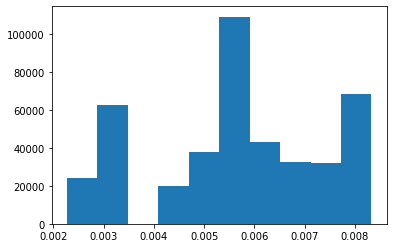

In [30]:
plt.hist(eve_gmmrep.apspread)

In [31]:
# various calculations on AP values

eve['ap'] = eve['burst_stripe_ap_reg']

# round ap for binning

eve['ap2'] = eve['burst_stripe_ap_reg'].round(2)
eve['stripe'] = eve['burst_stripe']
eve['stripe_id'] = eve['burst_stripe_id']

eve['stripe_pos'] = (3 * eve['stripe_id'] + 1.0).round(0) % 3 
eve['is_stripe'] = 0
eve.loc[eve.stripe_pos == 1, 'is_stripe'] = 1
    
eve['apmean'] = 0

inds = []
data = []

for nid,p in eve.groupby('nucleus_id'):
    inds.extend(p.index)
    s = p['burst_stripe_ap_reg'].mean()
    data.extend(len(p) * [s])
eve.loc[inds,'apmean'] = data

eve['apmean_corr'] = 0

inds = []
data = []

for nid,p in eve.groupby('nucleus_id'):
    inds.extend(p.index)
    s = p['burst_stripe_ap_reg_corr'].mean()
    data.extend(len(p) * [s])
eve.loc[inds,'apmean_corr'] = data

In [32]:
#
# track how the promoter state is changing over time
#

eve['change']  = 0
eve['toon']    = 0
eve['tooff']   = 0

inds = []
change = []
toon = []
tooff = []
nexton = []
nextoff = []

for nid,p in eve.groupby('nucleus_id'):
    l = p['v_state_all'].values
    d = l[1:] - l[:-1]
    d = np.insert(d,0,0)
    n = d[1:]
    n = np.insert(n,len(n),0)

    inds.extend(p.index)
    change.extend(d)
    toon.extend(np.where(d == 1,1,0))
    tooff.extend(np.where(d == -1,1,0))
    nexton.extend(np.where(n == 1,1,0))
    nextoff.extend(np.where(n == -1,1,0))

eve.loc[inds,'change']  = change
eve.loc[inds,'toon']    = toon
eve.loc[inds,'tooff']   = tooff

In [33]:
# for each point records the last time that nucleus was on and whether it was or wasn't on at all

eve['laston'] = -1
inds = []
lastons = []

for pid,p in eve.groupby('nucleus_id'):
    p.sort_values(['time'])
    last = -1
    t = p['time'].values
    l = p['v_state_all'].values

    laston = np.zeros(len(l))

    for i,f in enumerate(l):
        if f == 1:
            last = t[i]
        laston[i] = last

    inds.extend(p.index)
    lastons.extend(laston)   

eve.loc[inds,'laston'] = lastons

# 0 if nucleus has been on

eve['neveron'] = 1
eve.loc[eve['laston'] != -1,'neveron'] = 0
eve['wason'] = 1 - eve['neveron']


In [34]:
# activity over next/previous 10 minutes

eve['next10'] = 0
eve['prev10'] = 0

inds = []
next10s = []
prev10s = []

for pid,p in eve.groupby('nucleus_id'):
    p.sort_values(['time'])
    t = p['time'].values
    l = p['v_state_all'].values
    next10 = np.zeros(len(l))
    prev10 = np.zeros(len(l))
    for i in range(0,len(l)):
        v = l[i:i+30]
        if len(v) > 0:
            next10[i] = np.sum(v)/len(v)
        v = l[max(0,i-30):i]
        if len(v) > 0:
            prev10[i] = np.sum(v)/len(v)
    inds.extend(p.index)
    next10s.extend(next10)
    prev10s.extend(prev10)

eve.loc[inds,'next10'] = next10s
eve.loc[inds,'prev10'] = prev10s

eve['delta10'] = eve['next10'] - eve['prev10']

In [35]:
#
# when state changes, record length of new run 
#

eve['runlenp'] = 0
inds = []
runs = []
for pid,p in eve.sort_values('time').groupby('particle_id'):
    l = p['v_state_all'].values    
    i = 0
    t = np.zeros(len(l))
    for k,grp in itertools.groupby(l):
        v = list(grp)
        t[i] = len(v)
        i += len(v)
    inds.extend(p.index)
    runs.extend(t)
eve.loc[inds,'runlenp'] = runs

eve['runlenn'] = 0
inds = []
runs = []
for pid,p in eve.sort_values('time').groupby('nucleus_id'):
    l = p['v_state_all'].values    
    i = 0
    t = np.zeros(len(l))
    for k,grp in itertools.groupby(l):
        v = list(grp)
        t[i] = len(v)
        i += len(v)
    inds.extend(p.index)
    runs.extend(t)
eve.loc[inds,'runlenn'] = runs

In [36]:
# difference in activity between first 25 mins and last 25

eve['ons_diff'] = 0
inds = []
ondiff = []

for nid,p in eve.groupby('nucleus_id'):

    # divide ons by 18 for first 25 since first 7 mins mostly quiescent 

    ons_first25 = len(p[(p["toon"] == 1) & (p.time_m < 25)]) / 18
    ons_last25  = len(p[(p["toon"] == 1) & (p.time_m >= 25)]) / 25 
    if (ons_first25 + ons_last25) > 0:
        ons_diff = (ons_last25 - ons_first25)/(ons_first25 + ons_last25)
        inds.extend(p.index)
        ondiff.extend(len(p) * [ons_diff])

eve.loc[inds,'ons_diff'] = ondiff

In [37]:
eve_preap = eve.copy()

In [38]:
# number of nuclei remaining 

print ("Number of nuclei remaining: ", len(eve_preap.groupby('nucleus_id')))

# number of data points remaining 

print ("Number of data points remaining: ", len(eve_preap))

Number of nuclei remaining:  2959
Number of data points remaining:  430073


In [39]:
eve_e = pd.read_csv('Data/eve_data_longform_w_nuclei_witherror.csv')

In [40]:
eve_error = eve.merge(eve_e[['nucleus_id','time','fluo_error']], how = 'left', on=['nucleus_id','time'])

In [41]:
eve = eve[-eve['ap'].isnull()]

In [42]:
# number of nuclei remaining 

print ("Number of nuclei remaining: ", len(eve.groupby('nucleus_id')))

# number of data points remaining 

print ("Number of data points remaining: ", len(eve))

Number of nuclei remaining:  2959
Number of data points remaining:  430073


In [43]:
#
# create data frame with information on nuclei
#

nucdata = []
for nid,p in eve[-eve['ap'].isnull()].groupby('nucleus_id'):
    d = []
    d.append(nid)
    d.append(np.mean(p['ap'].values))
    d.append(np.min(p['stripe_id']))
    d.append(np.mean(p['stripe_id']))
    d.append(np.max(p['stripe_id']))
    d.append(np.sum(p['v_state_all']))
    d.append(np.sum(p['toon']))
    nucdata.append(d)
    
eve_nuc = pd.DataFrame.from_records(nucdata,columns=['nid','apmean','stripe_min','stripe_mean','stripe_max','act','bursts'])

eve_nuc = eve_nuc.set_index('nid')

In [44]:
inds = []
d = []

eve_nuc['ampean_corr'] = 0

for nid,p in eve[-eve['ap'].isnull()].groupby('nucleus_id'):
    inds.append(nid)
    d.append(np.mean(p['burst_stripe_ap_reg_corr'].values))
eve_nuc.loc[inds,'apmean_corr'] = d


In [45]:
eve_nuc['start'] = -1
eve_nuc['end'] = -1

nids = []
fb = []
lb = []

for nid,p in eve[-eve['ap'].isnull()].groupby('nucleus_id'):
    nids.append(nid)
    fb.append(np.min(p['time'].values))
    lb.append(np.max(p['time'].values))
    
eve_nuc.loc[nids,'start'] = fb
eve_nuc.loc[nids,'end'] = lb

eve_nuc['len'] = eve_nuc['end'] - eve_nuc['start']

In [46]:
eve_nuc['firstburst'] = -1
eve_nuc['lastburst'] = -1

nids = []
fb = []
lb = []

df = eve[-eve['ap'].isnull()]

for nid,p in df[df['v_state_all'] == 1].groupby('nucleus_id'):
    nids.append(nid)
    fb.append(np.min(p['time'].values))
    lb.append(np.max(p['time'].values))

eve_nuc.loc[nids,'firstburst'] = fb
eve_nuc.loc[nids,'lastburst'] = lb

In [47]:
eve_nuc['firstburst25'] = 100000
eve_nuc['lastburst25'] = -1

nids = []
fb = []
lb = []

df = eve[-eve['ap'].isnull()]
for nid,p in df[(df['v_state_all'] == 1) & (df.time_m >= 25)].groupby('nucleus_id'):
    nids.append(nid)
    fb.append(np.min(p['time'].values))
    lb.append(np.max(p['time'].values))

eve_nuc.loc[nids,'firstburst25'] = fb
eve_nuc.loc[nids,'lastburst25'] = lb

In [48]:
eve_nuc['ons'] = 0
eve_nuc['offs'] = 0
eve_nuc['toons'] = 0
eve_nuc['tooffs'] = 0

df = eve[-eve['ap'].isnull()]

nids = []
c = []
for nid,p in df.groupby('nucleus_id'):
    nids.append(nid)
    c.append(np.sum(p['v_state_all']))
eve_nuc.loc[nids,'ons'] = c

nids = []
c = []
for nid,p in df.groupby('nucleus_id'):
    nids.append(nid)
    c.append(len(p) - np.sum(p['v_state_all']))
eve_nuc.loc[nids,'offs'] = c

nids = []
c = []
for nid,p in df.groupby('nucleus_id'):
    nids.append(nid)
    c.append(np.sum(p['toon']))
eve_nuc.loc[nids,'toons'] = c

nids = []
c = []
for nid,p in df.groupby('nucleus_id'):
    nids.append(nid)
    c.append(np.sum(p['tooff']))
eve_nuc.loc[nids,'tooffs'] = c

In [49]:
eve_nuc['ons25'] = 0
eve_nuc['offs25'] = 0
eve_nuc['toons25'] = 0
eve_nuc['tooffs25'] = 0

df = eve[-eve['ap'].isnull()]

nids = []
c = []
for nid,p in df[df.time >= 25].groupby('nucleus_id'):
    nids.append(nid)
    c.append(np.sum(p['v_state_all']))
eve_nuc.loc[nids,'ons25'] = c

nids = []
c = []
for nid,p in df[df.time >= 25].groupby('nucleus_id'):
    nids.append(nid)
    c.append(len(p) - np.sum(p['v_state_all']))
eve_nuc.loc[nids,'offs25'] = c

nids = []
c = []
for nid,p in df[df.time >= 25].groupby('nucleus_id'):
    nids.append(nid)
    c.append(np.sum(p['toon']))
eve_nuc.loc[nids,'toons25'] = c

nids = []
c = []
for nid,p in df[df.time >= 25].groupby('nucleus_id'):
    nids.append(nid)
    c.append(np.sum(p['tooff']))
eve_nuc.loc[nids,'tooffs25'] = c

In [50]:
eve_nuc['ons25_nq'] = 0
eve_nuc['offs25_nq'] = 0
eve_nuc['toons25_nq'] = 0
eve_nuc['tooffs25_nq'] = 0

df = eve[-eve['ap'].isnull()]

nids = []
ons = []
offs = []
for nid,p in df[df.time >= 25].groupby('nucleus_id'):

    s = eve_nuc.loc[nid]['firstburst25']
    e = eve_nuc.loc[nid]['lastburst25']
    q = p[(p.time >= s) & (p.time <= e) ]
    if len(q) > 0:
        nids.append(nid)
        ons.append(np.sum(q['v_state_all']))
        offs.append(len(q) - np.sum(q['v_state_all']))

eve_nuc.loc[nids,'ons25_nq'] = ons
eve_nuc.loc[nids,'offs25_nq'] = offs

nids = []
toons = []
tooffs = []
for nid,p in df[df.time >= 25].groupby('nucleus_id'):
        s = eve_nuc.loc[nid]['firstburst25']
        e = eve_nuc.loc[nid]['lastburst25']
        q = p[(p.time >= s) & (p.time <= e) ]
        if len(q) > 0:
            nids.append(nid)
            toons.append(np.sum(q['toon']))
            tooffs.append(np.sum(q['tooff']))

eve_nuc.loc[nids,'toons25_nq'] = toons
eve_nuc.loc[nids,'tooffs25_nq'] = tooffs

In [51]:
eve_nuc['runlen25_nq'] = 0

df = eve[-eve['ap'].isnull()]

nids = []
runlens = []
for nid,p in df[df.time >= 25].groupby('nucleus_id'):

    s = eve_nuc.loc[nid]['firstburst25']
    e = eve_nuc.loc[nid]['lastburst25']
    q = p[(p.time >= s) & (p.time <= e) & (p['toon'] == 1)]
    if len(q) > 0:
        nids.append(nid)
        runlens.append(np.mean(q['runlenn']))

eve_nuc.loc[nids,'runlen25nq'] = runlens

In [52]:
eve_nuc['meanfluor'] = 0
eve_nuc['meanfluor25'] = 0
eve_nuc['meanfluor25_nq'] = 0

df = eve[-eve['ap'].isnull()]

inds = []
mf = []
mf25 = []
mf25nq = []

for nid,p in df.groupby('nucleus_id'):
    inds.append(nid)
    mf.append(np.mean(p['fluo_nonan']))
    mf25.append(np.mean(p[p.time_m >= 25]['fluo_nonan']))
    s = eve_nuc.loc[nid]['firstburst25']
    e = eve_nuc.loc[nid]['lastburst25']
    q = p[(p.time >= s) & (p.time <= e) ]
    mf25nq.append(np.mean(q['fluo_nonan']))
    
eve_nuc.loc[inds,'meanfluor'] = mf
eve_nuc.loc[inds,'meanfluor25'] = mf25
eve_nuc.loc[inds,'meanfluor25_nq'] = mf25nq

In [53]:
for i in [1,2,3,4,5,6,7]:
    c = "in_stripe%d" % i
    eve_nuc[c] = 0
    
    df = eve[-eve['ap'].isnull()]
    
    nids = []
    for nid,p in df[df.burst_stripe_id == i].groupby('nucleus_id'):
        nids.append(nid)

    eve_nuc.loc[nids,c] = 1

In [54]:
eve_nuc['stripe'] = 0

nids = []
stripes = []

for nid,p in eve[eve.time_m >= 25].groupby('nucleus_id'):
    
    s = [x for x in p['stripe'] if x > 0]
    if len(s) > 0:
        nids.append(nid)
        stripes.append(max(set(s),key=s.count))
    
    
    eve_nuc.loc[nids,'stripe'] = stripes

In [55]:
eve_nuc = eve_nuc.sort_values('apmean')

In [56]:
import datetime
t = datetime.datetime.now()
eve.to_pickle("eve_%s.pkl" % t.strftime("%m%d%Y_%H%M%S"))
eve_nuc.to_pickle("eve_nuc_%s.pkl" % t.strftime("%m%d%Y_%H%M%S"))
eve_movies.to_pickle("eve_movies_%s.pkl" % t.strftime("%m%d%Y_%H%M%S"))
eve_stripes.to_pickle("eve_stripes_%s.pkl" % t.strftime("%m%d%Y_%H%M%S"))

In [57]:
# make figures

In [58]:
fignums = {
    "traces_activity" : 3,
    "burst_modeling"  : 4,
    "stripe_fitting"  : 5,
    "kinetic_fingerprint" : 6,
    "stripe_formation" : 7,
    "bursting_regulation" : 8,
    "stripe_movement" : 9
}


In [59]:
#function for making heatmap figures

def hm(df,value,index,column,aggfunc,title="",cmap="jet",vmin=None,vmax=None,pdffile="",cbar_title="",cticks=[],cticklabels=[],figsize=(8,6),fill_value = None):
    if pdffile == "":
        pdffile = home_dir + "%d.pdf" % random.randrange(10000000,99999999)
    with PdfPages(pdffile) as pdf:
        fig,ax = plt.subplots(1,1, figsize=figsize)
        pt = pd.pivot_table(df,values=value,index=index,columns=column,aggfunc=aggfunc,fill_value=fill_value, margins=False, dropna=True)
        
        ylabel = index
        ylabels = []
        yticks = []
        if index == 'time':
            ylabel = "time(m) in cycle 14"
            for i,t in enumerate(pt.index):
                if t % 300 == 0:
                    ylabels.append(str(int(t/60)))
                    yticks.append(i)
        
        if index == 'time_m':
            ylabel = "time(m) in cycle 14"
            for i,t in enumerate(pt.index):
                if t % 5 == 0:
                    ylabels.append(t)
                    yticks.append(i)
        
        if index == 'time_m5':
            ylabel = "time(m) in cycle 14"
            for i,t in enumerate(pt.index):
                if t % 5 == 0:
                    ylabels.append(t)
                    yticks.append(t)

        xlabel = column
        xlabels = []         
        xticks = []
        if column == "ap2":
            xlabel = "fraction embryo length"
            for i,ap in enumerate(pt.columns):
                if ap == np.round(ap,1) and ap > 0.2:
                    xlabels.append(ap)
                    xticks.append(i)
        
        if column == "stripe_id":
            xlabel = "Stripe"
            for i,s in enumerate(pt.columns):
                if int(s) == s:
                    xlabels.append(int(s))
                    xticks.append(i)

        sns.heatmap(pt,cmap=cmap,ax=ax,vmin=vmin,vmax=vmax,yticklabels=ylabels,xticklabels=xlabels,cbar_kws={'label': cbar_title})

        ax.set_title(title)
        ax.set_ylabel(ylabel)
        ax.set_xlabel(xlabel)
        
        ax.set_yticks(yticks)
        h = ax.set_yticklabels(ylabels, rotation = 0)
        ax.set_xticks(xticks)
        h = ax.set_xticklabels(xlabels, rotation = 0)
        
        if len(cticks) > 0:
            cbar = ax.collections[0].colorbar
            cbar.set_ticks(cticks)
            cbar.set_ticklabels(cticklabels)

        fig.tight_layout()
        pdf.savefig()

In [69]:
fontsize_ticklabel = 8
fontsize_axislabel = 10
fontsize_title = 10
fontsize_legend = 8

cbar_label_font = matplotlib.font_manager.FontProperties(size=8)
    
def set_fonts():
    
    matplotlib.rcParams['font.sans-serif'] = "Arial"

    fontsize_ticklabel = 8
    fontsize_axislabel = 10
    fontsize_title = 10
    fontsize_legend = 8

    cbar_label_font = matplotlib.font_manager.FontProperties(size=8)

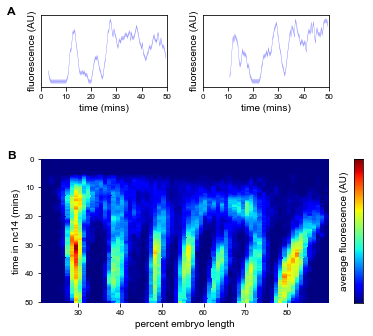

In [71]:
figid = "traces_activity"
fignum = fignums[figid]
set_fonts()

def plottrace(ax,pid):
    set_fonts()
    d = eve_error[eve_error.particle_id == pid]

    x = d['time']/60
    y = d['fluo']
    e = d['fluo_error']

    ax.plot(x,y,c='blue',label='fluo',linewidth=.1)
    ax.fill_between(x, y-e, y+e,facecolor='blue',alpha=.25)
    ax.set_xlim(0,50)
    ax.set_xlabel("time (mins)")
    ax.set_ylabel("fluorescence (AU)")
    ax.set_yticks([])
    xticks = [0,10,20,30,40,50]
    ax.set_xticks(xticks)
    ax.set_xticklabels([str(x) for x in xticks], fontsize = fontsize_ticklabel)

pdffile = image_dir + "Figure%d_Panels.pdf" % fignum

with PdfPages(pdffile) as pdf:
    
    cbar_label_font = matplotlib.font_manager.FontProperties(size=8)
    
    fig = plt.figure(figsize = (8.5,11))

    xi = [2.25,4.5,6.6]
    xf = [x/8.5 for x in xi]

    yi = [9,6]
    yf = [y/11 for y in yi]

    wi = [1.75,4,.125]
    wf = [w/8.5 for w in wi]

    hi = [1,2.0]
    hf = [h/11 for h in hi]

    #

    ax1 = fig.add_axes([xf[0],yf[0],wf[0],hf[0]])
    ax2 = fig.add_axes([xf[1],yf[0],wf[0],hf[0]])
    ax3 = fig.add_axes([xf[0],yf[1],wf[1],hf[1]])
    ax3_cb = fig.add_axes([xf[2],yf[1],wf[2],hf[1]])

                       
    # show selected raw traces
    
    # A
    plottrace(ax1,1.0163)
    plottrace(ax2,11.0448)

    # B    
    ax = ax3
    ax_cb = ax3_cb
      
    df = eve[(eve.time_m >= 0) & (eve.time_m <= 50)& (eve.ap2 > .2) & (eve.ap2 < .9)]
    value = 'fluo_nonan'
    index = 'time'
    column = 'ap2'
    aggfunc = 'mean'
    pt = pd.pivot_table(df,values=value,index=index,columns=column,aggfunc=aggfunc,margins=False, dropna=True)
    phm = sns.heatmap(pt,cmap='jet',ax=ax, cbar_ax=ax_cb)

    ax.set_ylabel("time in nc14 (mins)", fontsize = fontsize_axislabel)
    ylabels = []         
    yticks = []
    for i,t in enumerate(pt.index):
        if t % 600 == 0:
            ylabels.append(str(int(t/60)))
            yticks.append(i)
    ax.set_yticks(yticks)
    ax.set_yticklabels(ylabels, fontsize = fontsize_ticklabel)

    ax.set_xlabel("percent embryo length")
    xlabels = []         
    xticks = []
    for i,ap in enumerate(pt.columns):
        if ap == np.round(ap,1) and ap > 0.2:
            xlabels.append("%2d" % (ap * 100))
            xticks.append(i)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xlabels, rotation=0, fontsize = fontsize_ticklabel)

    cbar = ax.collections[0].colorbar
    cbar.set_ticks([])
    cbar.set_ticklabels([])
    cbar.set_label("average fluorescence (AU)",fontsize=fontsize_axislabel,labelpad=-23)
    ax_cb.set_frame_on(True)
 
    labeloffset = .055
    plt.figtext(xf[0]-labeloffset,yf[0]+hf[0],"A", {"fontsize" : 12, "fontweight" : 'bold'})
    plt.figtext(xf[0]-labeloffset,yf[1]+hf[1],"B", {"fontsize" : 12, "fontweight" : 'bold'})
    
 
    pdf.savefig()

In [72]:
d = eve_error[eve_error.particle_id == 1.0163]

x = d['time']/60
y = d['fluo']
e = d['fluo_error']

In [73]:
# autocorrelation to estimate transit time

d1 = 1
d2 = 20
v = {}
for d in range(d1,d2+1):
    v[d] = []

for nid,df in eve.groupby('particle_id'):
    f = df.fluo_nonan.values
    fd = f[1:] - f[:-1]
    for d in range(d1,d2+1):
        for p in range(0,len(fd)-d):
            v[d].append([fd[p],fd[p+d]])

autocorr = []
for d in range(d1,d2+1):
    x = np.array(v[d])
    autocorr.append([d,scipy.stats.pearsonr(x[:,0],x[:,1])[0]])

autocorr = np.array(autocorr)

In [74]:
# replicas of autocorrelation

trials = 100

autocorr_bs = []

np.random.seed(42)

# autocorrelation to estimate transit time

for t in range(0,trials):
    d1 = 1
    d2 = 20
    v = {}
    for d in range(d1,d2+1):
        v[d] = []

    for nid,df in eve.groupby('particle_id'):
        
        if np.random.rand() < .8:
            f = df.fluo_nonan.values
            fd = f[1:] - f[:-1]
            for d in range(d1,d2+1):
                for p in range(0,len(fd)-d):
                    v[d].append([fd[p],fd[p+d]])

    autocorr_rep = []
    for d in range(d1,d2+1):
        x = np.array(v[d])
        autocorr_rep.append([d,scipy.stats.pearsonr(x[:,0],x[:,1])[0]])

    autocorr_bs.append(np.array(autocorr_rep))

    

In [75]:
figid = "burst_modeling"
fignum = fignums[figid]
set_fonts()

pdffile = image_dir + "Figure%d_Panels.pdf" % fignum
with PdfPages(pdffile) as pdf:
    
    
    fig = plt.figure(figsize = (8.5,11))

    xi = [1,4.75]
    xf = [x/8.5 for x in xi]

    yi = [8.5,6.0,3.5]
    yf = [y/11 for y in yi]

    wi = [3.0]
    wf = [w/8.5 for w in wi]

    hi = [1.75]
    hf = [h/11 for h in hi]
    
    title_fontsize = 10
    colorbar_tick_fontsize = 8

    #
    
    ax1 = fig.add_axes([xf[0],yf[0],wf[0],hf[0]])
    ax2 = fig.add_axes([xf[0],yf[2],wf[0],hf[0]])
    
    trace_ax = []
    
    trace_ax.append(fig.add_axes([xf[1],yf[0],wf[0],hf[0]]))
    trace_ax.append(fig.add_axes([xf[1],yf[1],wf[0],hf[0]]))
    trace_ax.append(fig.add_axes([xf[1],yf[2],wf[0],hf[0]]))

    # Traces with fits

    pids = [1.0163,11.0448,5.0231]

    for i,pid in enumerate(pids):

        d = eve[eve.particle_id == pid]
        
        ax = trace_ax[i]
        ax2 = ax.twinx()
        
        x = np.array(d['time']/60)
        y = np.array(d['fluo'])

        ax.plot(x,d['v_fluo'],c='red',label='modeled fluo',linewidth=3,alpha=0.5)
        ax.plot(x,y,c='blue',label='observed fluo')
        ax.set_xlim(0,50)
        ax.set_ylim(0,)
        ax.set_xlabel("time (mins)")
        ax.set_ylabel("fluorescence (AU)")
        ax.set_yticks([])
        
        x = np.array(d['time']/60)
        y = np.array(d['v_state'])

        ax2.bar(x,y,width=.3333,color='green',linewidth=0)
        ax2.set_xlim(0,50)
        ax2.set_ylim(0,10.0)
        ax2.set_yticks([])   
        ax2.set_ylabel("inferred promoter state",color="green",fontsize=10,rotation=270,labelpad=13)
        
        
        ax.tick_params(axis='x', labelsize = fontsize_ticklabel)
        ax.tick_params(axis='y', labelsize = fontsize_ticklabel)
        
        if i == 2:
            ax.legend(fontsize=fontsize_legend, frameon = False)
    
    # plot autocorrelation used to estimate polymerase transit time

    ax = ax1
    
    for acr in autocorr_bs:
        ax.plot(acr[:,0] * 20,acr[:,1],alpha=.1,linewidth=1)
    
    ax.plot(autocorr[:,0] * 20,autocorr[:,1],color='red',linewidth=1)
    ax.set_xlim(20,400)
    ax.set_xlabel("autocorrelation lag (s)",fontsize=10)
    ax.set_xticks([0,100,200,300,400])
    ax.set_ylabel("autocorrelation",fontsize=10)
    ax.set_yticks([-.1,0,.1,.2,.3])
    ax.set_yticklabels(["-.1","0",".1",".2",".3"],fontsize=9)
    ax.set_title("polymerase transit time estimate",fontsize=10)
    

    # made up promoter state and matching fluorescence for illustration
    
    ps = np.array([0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,1,1,1,1,1,2,2,2,2,1,1,1,1,0,0,0,0,0,0,0,0,0])
    bs = np.array([1,1,1,1,1,1,1])
    fs = np.convolve(ps,bs)
    
    ax = ax2
    
    ax.plot(20 * np.arange(0,len(fs))/60,fs,c='red',linewidth=3,alpha=0.5,label='modeled fluo')
    ax.set_ylim(0,)
    ax.set_yticks([0,5,10])
    ax.tick_params(axis='x', labelsize = 9)
    ax.tick_params(axis='y', labelsize = 9)
    ax.set_xlabel("time (mins)",fontsize=10)
    ax.set_ylabel(r'fluorescence (units of $r * \Delta t$)')
    ax.legend(fontsize=8, frameon=False)

    ax2 = ax.twinx()
    ax2.bar(20 * np.arange(0,len(ps))/60,ps,width=.333,color='green',linewidth=0)
    ax2.set_ylim(0,12)
    ax2.set_yticks([])   
    ax2.set_ylabel("modeled promoter state",color="green",fontsize=10,rotation=270,labelpad=13)
    
    labeloffset_x = .065
    labeloffset_y = .01
    |
    plt.figtext(xf[0]-labeloffset_x,yf[0]+hf[0]+labeloffset_y,"A", {"fontsize" : 12, "fontweight" : 'bold'})
    plt.figtext(xf[0]-labeloffset_x,yf[1]+hf[0]+labeloffset_y,"B", {"fontsize" : 12, "fontweight" : 'bold'})
    plt.figtext(xf[0]-labeloffset_x,yf[2]+hf[0]+labeloffset_y,"C", {"fontsize" : 12, "fontweight" : 'bold'})
    plt.figtext(xf[1]-labeloffset_x,yf[0]+hf[0]+labeloffset_y,"D", {"fontsize" : 12, "fontweight" : 'bold'})
    plt.figtext(xf[1]-labeloffset_x,yf[1]+hf[0]+labeloffset_y,"E", {"fontsize" : 12, "fontweight" : 'bold'})
    plt.figtext(xf[1]-labeloffset_x,yf[2]+hf[0]+labeloffset_y,"F", {"fontsize" : 12, "fontweight" : 'bold'})

    pdf.savefig()

SyntaxError: invalid syntax (<ipython-input-75-1618a608da82>, line 117)

In [76]:
stripe_colors = pd.read_csv(home_dir + "stripe_color_RGB.csv")
cols = {}

for i,p in stripe_colors.iterrows():
    cols[int(p.stripe)] = [p.r,p.g,p.b]

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


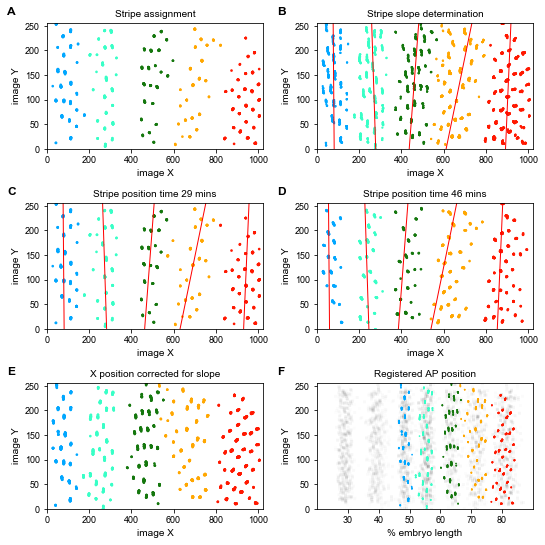

In [77]:
# figure illustrating stripe fitting process

figid = "stripe_fitting"
fignum = fignums[figid]
set_fonts()

pdffile = image_dir + "Figure%d_Panels.pdf" % fignum

with PdfPages(pdffile) as pdf:
    
    
    fig = plt.figure(figsize = (8.5,11))

    xi = [1,3.7,4.75,7.45]
    xf = [x/8.5 for x in xi]

    yi = [8.5,6.0,3.5]
    yf = [y/11 for y in yi]

    wi = [3.0]
    wf = [w/8.5 for w in wi]

    hi = [1.75]
    hf = [h/11 for h in hi]
    
    title_fontsize = 10
    colorbar_tick_fontsize = 8

    #

    ax1 = fig.add_axes([xf[0],yf[0],wf[0],hf[0]])
    ax2 = fig.add_axes([xf[2],yf[0],wf[0],hf[0]])
    ax3 = fig.add_axes([xf[0],yf[1],wf[0],hf[0]])
    ax4 = fig.add_axes([xf[2],yf[1],wf[0],hf[0]])
    ax5 = fig.add_axes([xf[0],yf[2],wf[0],hf[0]])
    ax6 = fig.add_axes([xf[2],yf[2],wf[0],hf[0]])

    
    # Gaussian mixture model to call stripes
    
    n = 5
    steps = 8
    times = np.linspace(1500,3000,steps)
    df = eve[(eve.movie == 2) & (eve.time >= times[0]) & (eve.time <= times[2]) & (eve.v_state_all == 1)]

    x = df['xPosF'].values
    y = df['yPosF'].values
    d = np.column_stack((x,y))
    o = gmm_stripe_nofit(d,n,trials=25)
    c = [cols[s+3] for s in o]
    
    ax = ax1
    
    ax.scatter(x,y,c=c,linewidth=0,s=7)
    ax.set_xlim(0,1024)
    ax.set_ylim(0,256)
    ax.set_xlabel("image X", fontsize=10)
    ax.set_ylabel("image Y", fontsize=10)
    ax.set_title("Stripe assignment", fontsize=10)
    
    ax.tick_params(axis='x', labelsize = 9)
    ax.tick_params(axis='y', labelsize = 9)

    # show line fit to all bustring stripe nuclei
    
    df = eve[(eve.movie == 2) & (eve.time >= 25 * 60) & (eve.v_state_all == 1)]
    
    x = df['xPosF'].values
    y = df['yPosF'].values
    bs = df['burst_stripe']
    c = [cols[int(s)] for s in bs]
    
    ax = ax2
    
    ax.scatter(x,y,linewidth=0,s=5,c=c)
    ax.set_xlim(0,1024)
    ax.set_ylim(0,256)
    ax.set_xlabel("image X", fontsize=10)
    ax.set_ylabel("image Y", fontsize=10)
    ax.set_title("Stripe slope determination",fontsize=10)
    
    ax.tick_params(axis='x', labelsize = 9)
    ax.tick_params(axis='y', labelsize = 9)
    
    for s in range(0,5):
        sinfo = eve_stripes.loc[2,s]
        m = sinfo['slope']
        b = sinfo['intercept']
        xp = range(0,1024)
        ax.plot(xp,xp*m+b,c='red',linewidth=1)
    
    # show fit of sloped line to data at different times
    
    df = eve[(eve.movie == 2) & (eve.time >= times[0]) & (eve.time <= times[2]) & (eve.v_state_all == 1)]

    x = df['xPosF'].values
    y = df['yPosF'].values
    bs = df['burst_stripe']
    c = [cols[int(s)] for s in bs]
    
    ax = ax3
    
    ax.scatter(x,y,c=c,linewidth=0,s=7)
    ax.set_xlim(0,1024)
    ax.set_ylim(0,256)
    ax.set_xlabel("image X", fontsize=10)
    ax.set_ylabel("image Y", fontsize=10)
    ax.set_title("Stripe position time %d mins" % np.round(times[1]/60,0), fontsize=10)
    
    ax.tick_params(axis='x', labelsize = 9)
    ax.tick_params(axis='y', labelsize = 9)
    
    for s in range(0,5):
        sinfo = eve_stripes.loc[2,s]
        m = sinfo['slope']
        sm = sinfo['b_slope']
        sb = sinfo['b_intercept']
        b = sm * times[1] + sb
        xp = range(0,1024)
        ax.plot(xp,xp*m+b,c='red',linewidth=1)

    
    
    df = eve[(eve.movie == 2) & (eve.time >= times[5]) & (eve.time <= times[7]) & (eve.v_state_all == 1)]

    x = df['xPosF'].values
    y = df['yPosF'].values
    bs = df['burst_stripe']
    c = [cols[int(s)] for s in bs]
    
    ax = ax4
    
    ax.scatter(x,y,c=c,linewidth=0,s=7)
    ax.set_xlim(0,1024)
    ax.set_ylim(0,256)
    ax.set_xlabel("image X", fontsize=10)
    ax.set_ylabel("image Y", fontsize=10)
    ax.set_title("Stripe position time %d mins" % np.round(times[6]/60,0), fontsize=10)
    
    ax.tick_params(axis='x', labelsize = 9)
    ax.tick_params(axis='y', labelsize = 9)
    
    for s in range(0,5):
        sinfo = eve_stripes.loc[2,s]
        m = sinfo['slope']
        sm = sinfo['b_slope']
        sb = sinfo['b_intercept']
        b = sm * times[6] + sb
        xp = range(0,1024)
        ax.plot(xp,xp*m+b,c='red',linewidth=1)

    # show correction for stripe angle
    
    df = eve[(eve.movie == 2) & (eve.time >= 30 * 60) & (eve.time <= 40 * 60) & (eve.v_state_all == 1)]

    x = df['burst_stripe_xPos_reg'].values
    y = df['yPosF'].values
    bs = df['burst_stripe']
    c = [cols[int(s)] for s in bs]
    
    ax = ax5
    
    ax.scatter(x,y,c=c,linewidth=0,s=7)
    ax.set_xlim(0,1024)
    ax.set_ylim(0,256)
    ax.set_xlabel("image X",fontsize=10)
    ax.set_ylabel("image Y",fontsize=10)
    ax.set_title("X position corrected for slope" % times[6],fontsize=10)
    ax.tick_params(axis='x', labelsize = 9)
    ax.tick_params(axis='y', labelsize = 9)

    # show stripes in registered AP position relative to stripes from other movies
    
    df = eve[(eve.movie != 2) & (eve.time >= 30 * 60) & (eve.time <= 40 * 60) & (eve.v_state_all == 1)]
    x = df['burst_stripe_ap_reg'].values
    y = df['yPosF'].values
    
    ax = ax6
    
    ax.scatter(x,y,c=[.1,.1,.1],linewidth=0,s=10,alpha=0.005)
    
    df = eve[(eve.movie == 2) & (eve.time >= 30 * 60) & (eve.time <= 40 * 60) & (eve.v_state_all == 1)]
    x = df['burst_stripe_ap_reg'].values
    y = df['yPosF'].values
    bs = df['burst_stripe']
    c = [cols[int(s)] for s in bs]
    ax.scatter(x,y,c=c,linewidth=0,s=3)

    ax.set_xlim(.2,.9)
    ax.set_ylim(0,256)
    ax.set_xticks([.3,.4,.5,.6,.7,.8])
    ax.set_xticklabels(["30","40","50","60","70","80"])
    ax.set_xlabel("% embryo length", fontsize=10)
    ax.set_ylabel("image Y", fontsize=10)
    ax.set_title("Registered AP position",fontsize=10)
    ax.tick_params(axis='x', labelsize = 9)
    ax.tick_params(axis='y', labelsize = 9)
    
    labeloffset_x = .065
    labeloffset_y = .01
    plt.figtext(xf[0]-labeloffset_x,yf[0]+hf[0]+labeloffset_y,"A", {"fontsize" : 12, "fontweight" : 'bold'})
    plt.figtext(xf[2]-labeloffset_x,yf[0]+hf[0]+labeloffset_y,"B", {"fontsize" : 12, "fontweight" : 'bold'})
    plt.figtext(xf[0]-labeloffset_x,yf[1]+hf[0]+labeloffset_y,"C", {"fontsize" : 12, "fontweight" : 'bold'})
    plt.figtext(xf[2]-labeloffset_x,yf[1]+hf[0]+labeloffset_y,"D", {"fontsize" : 12, "fontweight" : 'bold'})
    plt.figtext(xf[0]-labeloffset_x,yf[2]+hf[0]+labeloffset_y,"E", {"fontsize" : 12, "fontweight" : 'bold'})
    plt.figtext(xf[2]-labeloffset_x,yf[2]+hf[0]+labeloffset_y,"F", {"fontsize" : 12, "fontweight" : 'bold'})

    pdf.savefig()
    

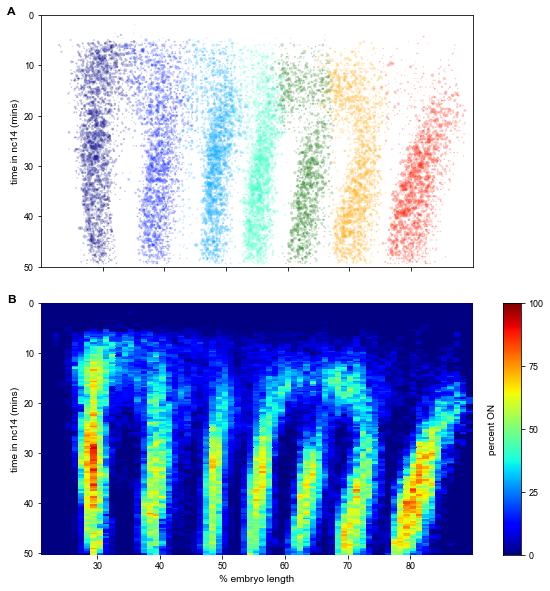

In [78]:
# figure showing all bursts with size reflecting burst duration

figid = "kinetic_fingerprint"
fignum = fignums[figid]

pdffile = image_dir + "Figure%d_Panels.pdf" % fignum

with PdfPages(pdffile) as pdf:
    fig = plt.figure(figsize = (8.5,11))
    
    xi = [1,7.425]
    xf = [x/8.5 for x in xi]

    yi = [6.5,2.5]
    yf = [y/11 for y in yi]

    wi = [6.0,.25]
    wf = [w/8.5 for w in wi]

    hi = [3.5]
    hf = [h/11 for h in hi]
    
    title_fontsize = 10
    colorbar_tick_fontsize = 8

    #

    ax1 = fig.add_axes([xf[0],yf[0],wf[0],hf[0]])
    ax2 = fig.add_axes([xf[0],yf[1],wf[0],hf[0]])
    ax2_cb = fig.add_axes([xf[1],yf[1],wf[1],hf[0]])

    p = eve[(eve.time_m >0) & (eve.time_m <50) & (eve.toon == 1)]
    x = p['ap'].values
    y = p['time'].values
    s = p['runlenn'].values
    bs = p['burst_stripe']
    c = [cols[int(s)] for s in bs]
    y = y/60
    
    ax1.scatter(x,y,s=s,c=c,linewidth=0,alpha=0.25,vmin=1,vmax=7)

    ax1.set_ylim(50,0)
    ax1.set_xlim(.2,.9)
    #ax1.set_xlabel("Fraction Embryo Length")
    ax1.set_ylabel("time in nc14 (mins)", fontsize=10)
    ax1.set_title("")
    ax1.set_xticks([.3,.4,.5,.6,.7,.8])
    #ax1.set_xticklabels(['.3','.4','.5','.6','.7','.8'])
    ax1.set_xticklabels([])
    ax1.tick_params(axis='x', labelsize = 9)
    ax1.tick_params(axis='y', labelsize = 9)
    
    df = eve[(eve.time_m >= 0) & (eve.time_m <= 50)& (eve.ap2 > .2) & (eve.ap2 < .9)]
    value = 'v_state_all'
    index = 'time'
    column = 'ap2'
    aggfunc = 'mean'
    pt = pd.pivot_table(df,values=value,index=index,columns=column,aggfunc=aggfunc,margins=False, dropna=True)

    phm = sns.heatmap(pt,cmap='jet',ax=ax2, cbar_ax=ax2_cb,vmin=0,vmax=1.0)

    ax2.set_ylabel("time in nc14 (mins)", fontsize=10)
    ylabels = []         
    yticks = []
    for i,t in enumerate(pt.index):
        if t % 600 == 0:
            ylabels.append(str(int(t/60)))
            yticks.append(i)
    ax2.set_yticks(yticks)
    ax2.set_yticklabels(ylabels)

    ax2.set_xlabel("% embryo length", fontsize=10)
    xlabels = []         
    xticks = []
    for i,ap in enumerate(pt.columns):
        if ap == np.round(ap,1) and ap > 0.2:
            xlabels.append("%d" % (ap * 100))
            xticks.append(i)
    ax2.set_xticks(xticks)
    ax2.set_xticklabels(xlabels, rotation = 0)
    ax2.tick_params(axis='x', labelsize = 9)
    ax2.tick_params(axis='y', labelsize = 9)

    cbar = ax2.collections[0].colorbar
    cbar.set_ticks([0,.25,.5,.75,1.0])
    cbar.set_ticklabels(["0","25","50","75","100"])
    cbar.ax.tick_params(labelsize=colorbar_tick_fontsize)
    cbar.set_label("percent ON", fontsize=10,labelpad=-55)
    cbar.ax.tick_params(labelsize=9)
    cbar_label_font = matplotlib.font_manager.FontProperties(size=10)
    ax2_cb.yaxis.label.set_font_properties(cbar_label_font)
    ax2_cb.set_frame_on(True)
    
    
    labeloffset_x = .055
    labeloffset_y = .0
    plt.figtext(xf[0]-labeloffset_x,yf[0]+hf[0]+labeloffset_y,"A", {"fontsize" : 12, "fontweight" : 'bold'})
    plt.figtext(xf[0]-labeloffset_x,yf[1]+hf[0]+labeloffset_y,"B", {"fontsize" : 12, "fontweight" : 'bold'})
    
    pdf.savefig()
    

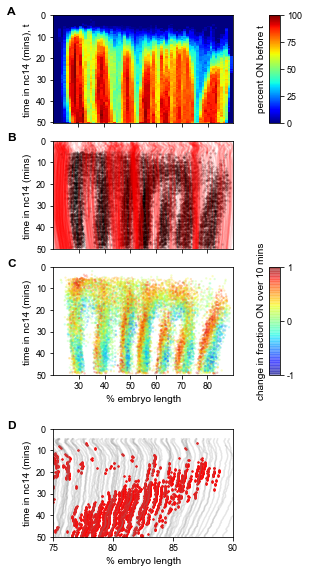

In [79]:
figid = "stripe_formation"
fignum = fignums[figid]

pdffile = image_dir + "Figure%d_Panels.pdf" % fignum

with PdfPages(pdffile) as pdf:
    
    
    fig = plt.figure(figsize = (8.5,11))

    xi = [3,6.0]
    xf = [x/8.5 for x in xi]

    yi = [8.5,6.75,5.0,2.75]
    yf = [y/11 for y in yi]

    wi = [2.5,.15,2.5,.15]
    wf = [w/8.5 for w in wi]

    hi = [1.5]
    hf = [h/11 for h in hi]
    
    title_fontsize = 10
    colorbar_tick_fontsize = 8


    ax1 = fig.add_axes([xf[0],yf[0],wf[0],hf[0]])
    ax1_cb = fig.add_axes([xf[1],yf[0],wf[1],hf[0]])
    
    ax2 = fig.add_axes([xf[0],yf[1],wf[0],hf[0]])
    #ax2_cb = fig.add_axes([xf[1],yf[1],wf[1],hf[0]])
    
    ax3 = fig.add_axes([xf[0],yf[2],wf[0],hf[0]])
    ax3_cb = fig.add_axes([xf[1],yf[2],wf[1],hf[0]])
    
    ax4 = fig.add_axes([xf[0],yf[3],wf[0],hf[0]])
    #ax4_cb = fig.add_axes([xf[1],yf[1],wf[1],hf[0]])
        
    
    cbar_label_font = matplotlib.font_manager.FontProperties(size=9)
    colorbar_tick_fontsize = 9
    
    # A
    
    ax = ax1
    ax_cb = ax1_cb
    
    df = eve[(eve.time_m >= 0) & (eve.time_m <= 50)& (eve.ap2 > .2) & (eve.ap2 < .9)]
    value = 'wason'
    index = 'time'
    column = 'ap2'
    aggfunc = 'mean'
    pt = pd.pivot_table(df,values=value,index=index,columns=column,aggfunc=aggfunc,margins=False, dropna=True)
    phm = ax.imshow(pt.values,aspect='auto',cmap='jet')

    ax.set_ylabel("time in nc14 (mins), t ", fontsize=10)
    ylabels = []         
    yticks = []
    for i,t in enumerate(pt.index):
        if t % 600 == 0:
            ylabels.append(str(int(t/60)))
            yticks.append(i)
    ax.set_yticks(yticks)
    ax.set_yticklabels(ylabels,fontsize=9)
    xlabels = []         
    xticks = []
    for i,ap in enumerate(pt.columns):
        if ap == np.round(ap,1) and ap > 0.2:
            xticks.append(i)
    ax.set_xticks(xticks)
    ax.set_xticklabels([])
    ax.tick_params(axis='x', labelsize = 9)
    ax.tick_params(axis='y', labelsize = 9)

    cbar = fig.colorbar(phm,cax=ax_cb)
    cbar.set_ticks([0,.25,.5,.75,1.0])
    cbar.set_ticklabels(["0","25","50","75","100"])
    cbar.set_label("percent ON before t", labelpad = -45, fontsize=10)
    cbar.ax.tick_params(labelsize=9)         
    
    # B
    
    ax = ax2

    nucs = eve_nuc[eve_nuc.bursts == 0].index
    df = eve[eve.nucleus_id.isin(nucs)]

    for pid,p in df.groupby('nucleus_id'):
        x = p['ap']
        y = p['time']/60
        ax.plot(x,y,alpha=0.1,c='red')

    df = eve[(eve.toon == 1)]
    ap = df['ap']
    time = df['time']/60
    ax.scatter(ap,time,5,linewidth=0,color='black',alpha=0.25)
    ax.set_ylim(50,0)
    ax.set_xlim(.2,.9)
    ax.set_ylabel("time in nc14 (mins) ")
    ax.set_xticks([.3,.4,.5,.6,.7,.8])
    ax.set_xticklabels([])
    ax.tick_params(axis='x', labelsize = 9)
    ax.tick_params(axis='y', labelsize = 9)

    
    # C

    ax = ax3
    ax_cb = ax3_cb
     
    p = eve[(eve.time_m >0) & (eve.time_m <50) & (eve.toon == 1)]
    x = p['ap'].values
    y = p['time'].values
    y = y/60
    c = p['ons_diff']
    c = p['delta10']
    sc = ax.scatter(x,y,5,c=c,linewidth=0,alpha=0.25,cmap='jet',vmin=-1.0,vmax=1.0)

    ax.set_ylim(50,0)
    ax.set_xlim(.2,.9)
    ax.set_ylabel("time in nc14 (mins) ",fontsize=10)
    ax.set_xlabel("% embryo length",fontsize=10)
    ax.set_xticks([.3,.4,.5,.6,.7,.8])
    ax.set_xticklabels(['30','40','50','60','70','80'])
    ax.tick_params(axis='x', labelsize = 9)
    ax.tick_params(axis='y', labelsize = 9)

    cbar = fig.colorbar(sc,cax=ax_cb)
    #cbar.set_ticks([-1.0,0,1.0])
    #cbar.set_ticklabels(["-1.0","0","1.0"])
    cbar.set_ticks([-1.0,0,1.0])
    cbar.set_ticklabels(["-1","0","1"])   
    cbar.set_label('change in fraction ON over 10 mins', fontsize=10, labelpad = -38)
    cbar.ax.tick_params(labelsize=9)
    
    
    # D
    
    ax = ax4
    
    df = eve[(eve.time_m >=5) & (eve.time_m <=50) & (eve.ap > .75)  & (eve.movie == 6) ]

    for nid,p in df.groupby('nucleus_id'):
        x = p['ap'].values
        y = p['time'].values
        y = y/60
        cd = p['is_stripe']
        f = -1
        l = -1
        for i,a in enumerate(cd):
            if a == 1:
                if f == -1:
                    f = i
                l = i
        x0 = []
        y0 = []
        if f != -1:
            for i in range(f,l+1):
                x0.append(x[i])
                y0.append(y[i])
        c = np.where(cd == 1,'g','b' )
        s = np.where(cd == 1,5,0)
        ax.plot(x,y,alpha=0.2,c='gray')
        
    df = df[df.v_state_all == 1]
    ax.scatter(df['ap'],df['time']/60,s=5,c='red',linewidth=0)

    ax.set_ylim(50,0)
    ax.set_xlim(.75,.9)
    ax.set_ylabel("time in nc14 (mins)",fontsize=10)
    
    df = df[df.v_state_all == 1]
    ax.scatter(df['ap'],df['time']/60,s=5,c='red',linewidth=0)

    ax.set_xticks([.75,.8,.85,.9])
    ax.set_xticklabels(['75','80','85','90'])
    ax.set_xlabel("% embryo length",fontsize=10)
    ax.tick_params(axis='x', labelsize = 9)
    ax.tick_params(axis='y', labelsize = 9)

    labeloffset_x = .075
    labeloffset_y = 0
    plt.figtext(xf[0]-labeloffset_x,yf[0]+hf[0]+labeloffset_y,"A", {"fontsize" : 12, "fontweight" : 'bold'})
    plt.figtext(xf[0]-labeloffset_x,yf[1]+hf[0]+labeloffset_y,"B", {"fontsize" : 12, "fontweight" : 'bold'})
    plt.figtext(xf[0]-labeloffset_x,yf[2]+hf[0]+labeloffset_y,"C", {"fontsize" : 12, "fontweight" : 'bold'})
    plt.figtext(xf[0]-labeloffset_x,yf[3]+hf[0]+labeloffset_y,"D", {"fontsize" : 12, "fontweight" : 'bold'})
    #plt.figtext(xf[0]-labeloffset_x,yf[2]+hf[0]+labeloffset_y,"C", {"fontsize" : 14, "fontweight" : 'bold'})
    
    pdf.savefig()


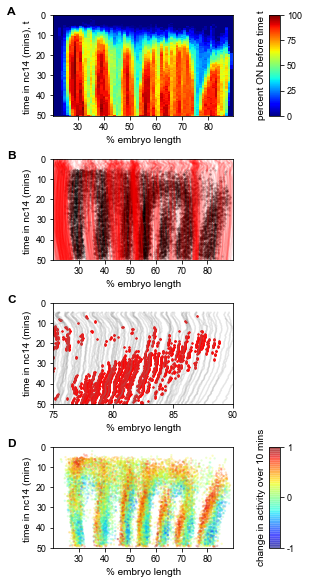

In [80]:
figid = "stripe_formation"
fignum = fignums[figid]

pdffile = image_dir + "Figure%d_Panels.pdf" % fignum

with PdfPages(pdffile) as pdf:
    
    
    fig = plt.figure(figsize = (8.5,11))

    xi = [3,6.0]
    xf = [x/8.5 for x in xi]

    yi = [9,7,5,3]
    yf = [y/11 for y in yi]

    wi = [2.5,.15,2.5,.15]
    wf = [w/8.5 for w in wi]

    hi = [1.4]
    hf = [h/11 for h in hi]
    
    title_fontsize = 10
    colorbar_tick_fontsize = 8


    ax1 = fig.add_axes([xf[0],yf[0],wf[0],hf[0]])
    ax1_cb = fig.add_axes([xf[1],yf[0],wf[1],hf[0]])
    
    ax2 = fig.add_axes([xf[0],yf[1],wf[0],hf[0]])
    #ax2_cb = fig.add_axes([xf[1],yf[1],wf[1],hf[0]])
    
    ax3 = fig.add_axes([xf[0],yf[2],wf[0],hf[0]])
    #ax3_cb = fig.add_axes([xf[1],yf[2],wf[1],hf[0]])
    
    ax4 = fig.add_axes([xf[0],yf[3],wf[0],hf[0]])
    ax4_cb = fig.add_axes([xf[1],yf[3],wf[1],hf[0]])
        
    
    cbar_label_font = matplotlib.font_manager.FontProperties(size=9)
    colorbar_tick_fontsize = 9
    
    # A
    
    ax = ax1
    ax_cb = ax1_cb
    
    df = eve[(eve.time_m >= 0) & (eve.time_m <= 50)& (eve.ap2 > .2) & (eve.ap2 < .9)]
    value = 'wason'
    index = 'time'
    column = 'ap2'
    aggfunc = 'mean'
    pt = pd.pivot_table(df,values=value,index=index,columns=column,aggfunc=aggfunc,margins=False, dropna=True)
    phm = ax.imshow(pt.values,aspect='auto',cmap='jet')

    ax.set_ylabel("time in nc14 (mins), t ", fontsize=10)
    ylabels = []         
    yticks = []
    for i,t in enumerate(pt.index):
        if t % 600 == 0:
            ylabels.append(str(int(t/60)))
            yticks.append(i)
    ax.set_yticks(yticks)
    ax.set_yticklabels(ylabels,fontsize=9)
    xlabels = []         
    xticks = []
    for i,ap in enumerate(pt.columns):
        if ap == np.round(ap,1) and ap > 0.2:
            xticks.append(i)
    ax.set_xticks(xticks)
    ax.set_xticklabels(['30','40','50','60','70','80'])
    ax.set_xlabel("% embryo length",fontsize=10)
    ax.tick_params(axis='x', labelsize = 9)
    ax.tick_params(axis='y', labelsize = 9)

    cbar = fig.colorbar(phm,cax=ax_cb)
    cbar.set_ticks([0,.25,.5,.75,1.0])
    cbar.set_ticklabels(["0","25","50","75","100"])
    cbar.set_label("percent ON before time t", labelpad = -45, fontsize=10)
    cbar.ax.tick_params(labelsize=9)         
    
    # B
    
    ax = ax2

    nucs = eve_nuc[eve_nuc.bursts == 0].index
    df = eve[eve.nucleus_id.isin(nucs)]

    for pid,p in df.groupby('nucleus_id'):
        x = p['ap']
        y = p['time']/60
        ax.plot(x,y,alpha=0.1,c='red')

    df = eve[(eve.toon == 1)]
    ap = df['ap']
    time = df['time']/60
    ax.scatter(ap,time,5,linewidth=0,color='black',alpha=0.25)
    ax.set_ylim(50,0)
    ax.set_xlim(.2,.9)
    ax.set_ylabel("time in nc14 (mins) ")
    ax.set_xticks([.3,.4,.5,.6,.7,.8])
    ax.set_xticklabels(['30','40','50','60','70','80'])
    ax.set_xlabel("% embryo length",fontsize=10)
    ax.tick_params(axis='x', labelsize = 9)
    ax.tick_params(axis='y', labelsize = 9)

    
    # C

    ax = ax4
    ax_cb = ax4_cb
     
    p = eve[(eve.time_m >0) & (eve.time_m <50) & (eve.toon == 1)]
    x = p['ap'].values
    y = p['time'].values
    y = y/60
    c = p['ons_diff']
    c = p['delta10']
    sc = ax.scatter(x,y,5,c=c,linewidth=0,alpha=0.25,cmap='jet',vmin=-1.0,vmax=1.0)

    ax.set_ylim(50,0)
    ax.set_xlim(.2,.9)
    ax.set_ylabel("time in nc14 (mins) ",fontsize=10)
    ax.set_xlabel("% embryo length",fontsize=10)
    ax.set_xticks([.3,.4,.5,.6,.7,.8])
    ax.set_xticklabels(['30','40','50','60','70','80'])
    ax.tick_params(axis='x', labelsize = 9)
    ax.tick_params(axis='y', labelsize = 9)

    cbar = fig.colorbar(sc,cax=ax_cb)
    #cbar.set_ticks([-1.0,0,1.0])
    #cbar.set_ticklabels(["-1.0","0","1.0"])
    cbar.set_ticks([-1.0,0,1.0])
    cbar.set_ticklabels(["-1","0","1"])   
    cbar.set_label('change in activity over 10 mins', fontsize=10, labelpad = -38)
    cbar.ax.tick_params(labelsize=9)
    
    
    # D
    
    ax = ax3
    
    df = eve[(eve.time_m >=5) & (eve.time_m <=50) & (eve.ap > .75)  & (eve.movie == 6) ]

    for nid,p in df.groupby('nucleus_id'):
        x = p['ap'].values
        y = p['time'].values
        y = y/60
        cd = p['is_stripe']
        f = -1
        l = -1
        for i,a in enumerate(cd):
            if a == 1:
                if f == -1:
                    f = i
                l = i
        x0 = []
        y0 = []
        if f != -1:
            for i in range(f,l+1):
                x0.append(x[i])
                y0.append(y[i])
        c = np.where(cd == 1,'g','b' )
        s = np.where(cd == 1,5,0)
        ax.plot(x,y,alpha=0.2,c='gray')
        
    df = df[df.v_state_all == 1]
    ax.scatter(df['ap'],df['time']/60,s=5,c='red',linewidth=0)

    ax.set_ylim(50,0)
    ax.set_xlim(.75,.9)
    ax.set_ylabel("time in nc14 (mins)",fontsize=10)
    
    df = df[df.v_state_all == 1]
    ax.scatter(df['ap'],df['time']/60,s=5,c='red',linewidth=0)

    ax.set_xticks([.75,.8,.85,.9])
    ax.set_xticklabels(['75','80','85','90'])
    ax.set_xlabel("% embryo length",fontsize=10)
    ax.tick_params(axis='x', labelsize = 9)
    ax.tick_params(axis='y', labelsize = 9)

    labeloffset_x = .075
    labeloffset_y = 0
    plt.figtext(xf[0]-labeloffset_x,yf[0]+hf[0]+labeloffset_y,"A", {"fontsize" : 12, "fontweight" : 'bold'})
    plt.figtext(xf[0]-labeloffset_x,yf[1]+hf[0]+labeloffset_y,"B", {"fontsize" : 12, "fontweight" : 'bold'})
    plt.figtext(xf[0]-labeloffset_x,yf[2]+hf[0]+labeloffset_y,"C", {"fontsize" : 12, "fontweight" : 'bold'})
    plt.figtext(xf[0]-labeloffset_x,yf[3]+hf[0]+labeloffset_y,"D", {"fontsize" : 12, "fontweight" : 'bold'})
    #plt.figtext(xf[0]-labeloffset_x,yf[2]+hf[0]+labeloffset_y,"C", {"fontsize" : 14, "fontweight" : 'bold'})
    
    pdf.savefig()


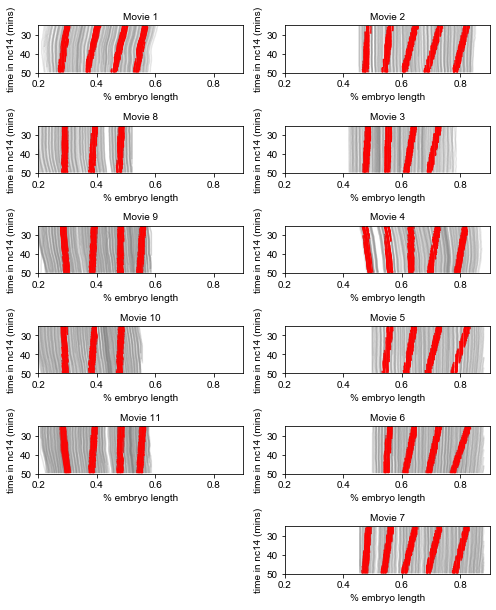

In [81]:
figid = "stripe_formation"
fignum = fignums[figid]

pdffile = image_dir + "Figure%d-S1_Panels.pdf" % fignum

with PdfPages(pdffile) as pdf:
    fig,ax = plt.subplots(6,2,figsize=(7,8.5))

    for mi,movie in enumerate([1,8,9,10,11,0,2,3,4,5,6,7]):

        df = eve[(eve.time_m >25) & (eve.time_m <50) & (eve.ap > .2) & (eve.ap < .88)& (eve.movie == movie) ]
        pr = mi % 6
        pc = int(mi/6)
        for nid,p in df.groupby('nucleus_id'):
            x = p['ap'].values
            y = p['time'].values
            y = y/60
            cd = p['is_stripe']
            f = -1
            l = -1
            for i,a in enumerate(cd):
                if a == 1:
                    if f == -1:
                        f = i
                    l = i
            x0 = []
            y0 = []
            if f != -1:
                for i in range(f,l+1):
                    x0.append(x[i])
                    y0.append(y[i])
            c = np.where(cd == 1,'g','b' )
            s = np.where(cd == 1,5,0)
            ax[pr][pc].plot(x,y,alpha=0.2,c='gray')
            ax[pr][pc].plot(x0,y0,c='red')
        ax[pr][pc].set_ylim(50,25)
        ax[pr][pc].set_xlim(.2,.9)
        ax[pr][pc].set_xlabel("% embryo length",fontsize=10)
        ax[pr][pc].set_ylabel("time in nc14 (mins)",fontsize=10)
        ax[pr][pc].set_title("Movie %d" % (movie), fontsize=10)
            
    ax[5][0].axis('off')
    ax[5][0].set_title('')
    plt.tight_layout()

    pdf.savefig()

In [82]:
fb = pd.read_csv("Data/w7_K3_t0_fluo_hmm_results_final.csv")

stripe_colors = pd.read_csv(home_dir + "stripe_color_RGB.csv")
cols = {}

for i,p in stripe_colors.iterrows():
    cols[int(p.stripe)] = [p.r,p.g,p.b]
    

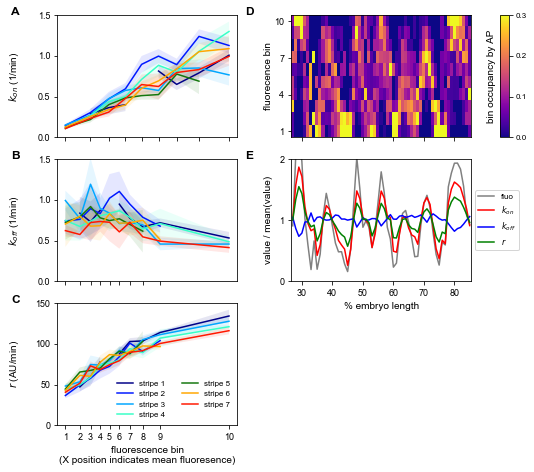

In [85]:
figid = "bursting_regulation"
fignum = fignums[figid]

fb0 = fb[fb.stripe_id == 0]

pdffile = image_dir + "Figure%d_Panels.pdf" % fignum

from matplotlib import rc

# activate latex text rendering
rc('text', usetex=False)

with PdfPages(pdffile) as pdf:
    
    fig = plt.figure(figsize = (8.5,11))

    xi = [1.25,4.5,7.4]
    xf = [x/8.5 for x in xi]

    yi = [8.5,6.5,4.5]
    yf = [y/11 for y in yi]

    wi = [2.5,.125]
    wf = [w/8.5 for w in wi]

    hi = [1.70]
    hf = [h/11 for h in hi]
    
    title_fontsize = 10
    colorbar_tick_fontsize = 8


    ax1 = fig.add_axes([xf[0],yf[0],wf[0],hf[0]])    
    ax2 = fig.add_axes([xf[0],yf[1],wf[0],hf[0]])  
    ax3 = fig.add_axes([xf[0],yf[2],wf[0],hf[0]])
    ax4  = fig.add_axes([xf[1],yf[0],wf[0],hf[0]])
    ax4_cb = fig.add_axes([xf[2],yf[0],wf[1],hf[0]])
    
    ax5 = fig.add_axes([xf[1],yf[1],wf[0],hf[0]])
    

    ax = ax1

    for s in [1,2,3,4,5,6,7]:
        df = fb[(fb.stripe_id == s) & (fb.fluo_bin <= 9)]
        x = df.mean_fluo
        y = df.kon
        e = df.kon_err
        ax.plot(x,y,c=cols[s])
        ax.fill_between(x, y-e, y+e,facecolor=cols[s],alpha=.1)
    
    ax.set_ylim(0,1.5)
    ax.set_yticks([0,.5,1.0,1.5])
    ax.set_ylabel("$\it{k}$$_{on}$ (1/min)",fontsize=10)
    ax.set_xticks(fb[(fb.stripe_id == 0) & (fb.fluo_bin <=9)].mean_fluo.values)
    ax.set_xticklabels([])
    ax.tick_params(axis='x', labelsize = 9)
    ax.tick_params(axis='y', labelsize = 9)

    
    ax = ax2

    for s in [1,2,3,4,5,6,7]:
        df = fb[fb.stripe_id == s]
        x = df.mean_fluo
        y = df.koff
        e = df.koff_err
        ax.plot(x,y,c=cols[s])
        ax.fill_between(x, y-e, y+e,facecolor=cols[s],alpha=.1)
    
    ax.set_ylim(0,1.5)
    ax.set_yticks([0,.5,1.0,1.5])
    ax.set_ylabel("$\it{k}$$_{off}$ (1/min)", fontsize=10)   
    ax.set_xticks(fb[(fb.stripe_id == 0) & (fb.fluo_bin <= 9)].mean_fluo.values)
    ax.set_xticklabels([])
    ax.tick_params(axis='x', labelsize = 9)
    ax.tick_params(axis='y', labelsize = 9)
        
    ax = ax3

    for s in [1,2,3,4,5,6,7]:
        df = fb[fb.stripe_id == s]
        x = df.mean_fluo
        y = df.r
        e = df.r_err
        ax.plot(x,y,c=cols[s],label="stripe " + str(s))
        ax.fill_between(x, y-e, y+e,facecolor=cols[s],alpha=.1)
   
    ax.set_ylim(0,150)
    ax.set_yticks([0,50,100,150])
    ax.set_ylabel("$\it{r}$ (AU/min)")
    ax.set_xticks(fb[fb.stripe_id == 0].mean_fluo.values)
    ax.set_xticklabels([1,2,3,4,5,6,7,8,9,10])
    ax.set_xlabel("fluorescence bin\n(X position indicates mean fluoresence)")
    ax.legend(fontsize=8,frameon=False,loc='lower right',ncol=2)
    ax.tick_params(axis='x', labelsize = 9)
    ax.tick_params(axis='y', labelsize = 9)
    
    # 

    fbb = pd.read_csv("Data/fluo_bin_bin.csv")
    df = eve[(~eve.particle_id.isna()) & (eve.time_m >=25)][['particle_id','ap_registered','fluo']]
    pap = df.groupby('particle_id').mean()
    pap.columns = list(pap.columns)
    pap = pap.merge(fbb,left_on = 'particle_id', right_on = "ParticleID")
    pap['ap2'] = np.round(pap.ap_registered,2)
    fbbyap = pd.pivot_table(pap[(pap.ap2 >= .27) & (pap.ap2 < .86)],index='FluoBin',columns='ap2',values='ap_registered',aggfunc=len).fillna(0)
    fbbyap.columns = list(fbbyap.columns)
    
    #df = df.drop(drops,axis=1)
    fbbyap = fbbyap.sort_values('FluoBin',ascending=True)
    fbbyap = fbbyap / fbbyap.sum(axis=0)
    
    ax = ax4
    ax_cb = ax4_cb
        
    pltdata = fbbyap.values
    im = ax.imshow(pltdata,vmin=0,vmax=.3,cmap='plasma',aspect='auto')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
    ax.set_xlim(-.5,pltdata.shape[1]-.5)
    ax.set_ylim(-.5,pltdata.shape[0]-.5)
    ax.set_xticks([3,13,23,33,43,53])
    ax.set_yticks([0,3,6,9])
    ax.set_yticklabels(['1','4','7','10'],fontsize=9)
    ax.set_ylabel("fluorecence bin",fontsize=10)
    
    cbar = fig.colorbar(im,cax=ax_cb)
    cbar.set_ticks([0,0.1,0.2,0.3])
    cbar.set_label('bin occupancy by AP',fontsize=10,labelpad=-40)
    cbar.ax.tick_params(labelsize=colorbar_tick_fontsize)     

    
    #
    
    ax = ax5
    df = pap[(pap.ap2 >= .27) & (pap.ap2 < .86)].merge(fb0,left_on = "FluoBin",right_on='fluo_bin',how='left').groupby('ap2').mean().reset_index()
    df['fluo'] = df['fluo'] / np.mean(df['fluo'])
    df['kon'] = df['kon'] / np.mean(df['kon'])
    df['koff'] = df['koff'] / np.mean(df['koff'])
    df['r'] = df['r'] / np.mean(df['r'])
    
    ax.plot(df.ap2,df.fluo,color='gray',label='fluo')
    ax.plot(df.ap2,df.kon,color='red',label='$\it{k}$$_{on}$')
    ax.plot(df.ap2,df.koff,color='blue',label='$\it{k}$$_{off}$')
    ax.plot(df.ap2,df.r,color='green', label='$\it{r}$')
    ax.set_xlim(.265,.855)
    ax.set_ylim(0,2.0)
    ax.set_yticks([0,1.0,2.0])
    ax.set_xticks([.3,.4,.5,.6,.7,.8])
    ax.set_xticklabels(['30','40','50','60','70','80'])
    ax.tick_params(axis='x', labelsize = 9)
    ax.tick_params(axis='y', labelsize = 9)
    ax.set_xlabel("% embryo length", fontsize=10)
    ax.set_ylabel("value / mean(value)",fontsize=10)
    #plt.legend()
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=8)

    label_x = -.2
    ax1.yaxis.set_label_coords(label_x, 0.5)
    ax2.yaxis.set_label_coords(label_x, 0.5)
    ax3.yaxis.set_label_coords(label_x, 0.5)   
    
    label_x = -.1
    ax4.yaxis.set_label_coords(label_x, 0.5)
    ax5.yaxis.set_label_coords(label_x, 0.5)
    
    labeloffset_x = .075
    labeloffset_y = .0
    plt.figtext(xf[0]-labeloffset_x,yf[0]+hf[0]+labeloffset_y,"A", {"fontsize" : 12, "fontweight" : 'bold'})
    plt.figtext(xf[0]-labeloffset_x,yf[1]+hf[0]+labeloffset_y,"B", {"fontsize" : 12, "fontweight" : 'bold'})
    plt.figtext(xf[0]-labeloffset_x,yf[2]+hf[0]+labeloffset_y,"C", {"fontsize" : 12, "fontweight" : 'bold'})
    plt.figtext(xf[1]-labeloffset_x,yf[0]+hf[0]+labeloffset_y,"D", {"fontsize" : 12, "fontweight" : 'bold'})
    plt.figtext(xf[1]-labeloffset_x,yf[1]+hf[0]+labeloffset_y,"E", {"fontsize" : 12, "fontweight" : 'bold'})

    
    pdf.savefig()
    

In [87]:
fig, ax = plt.subplots(figsize=(10,6))

df = eve[(eve.time == 0) & (eve.v_state_all == 1)]
x = df.ap
#x = df.burst_stripe_ap
y = df.yPosmean
s = 5 * (df.v_state_all - 1.0)
c = [cols[int(st)] for st in df.burst_stripe] 
    
sc = ax.scatter(x,y,s=s,c=c)
ax.set_xlim(0,1)
ax.set_ylim(1,256)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("%02d mins" % 0)

def animate(t):
    df = eve[(eve.time == t) & (eve.v_state_all == 1)]
    x = df.ap
    #x = df.burst_stripe_ap
    y = df.yPosmean
    s = 6 * (df.v_state)
    c = [cols[int(st)] for st in df.burst_stripe] 
    sc.set_offsets(np.c_[x,y])
    sc.set_color(c)
    sc.set_sizes(s)
    ax.set_title("%02d mins" % int(t/60))
    ax.set_xlabel("fraction embryo length")
    ax.set_ylabel("y position")

    #sc.set_facecolors(c)

ani = matplotlib.animation.FuncAnimation(fig, animate, 
                frames=np.arange(0,3000,20), repeat=True) 

Writer = animation.writers['ffmpeg']
writer = Writer(fps=10, metadata=dict(artist='Me'), bitrate=1800)

ani.save(movie_dir + "Video24.mp4", writer=writer)

plt.close(fig)